### Import relevant modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
from scipy.ndimage import gaussian_filter
from scipy import stats

from dipy.reconst.dki import DiffusionKurtosisModel
from dipy.io.image import load_nifti, save_nifti
from dipy.io.gradients import read_bvals_bvecs
from dipy.core.gradients import gradient_table

import statsmodels.api as sm
import pylab

Denoising code. 

Note: function genpca is a function that allows one to use all different denoising tested in this work. This function was adapted from the denoising procedures in the diffusion in python package (DIPY). I intend to update the DIPY procedures with the work done for this study.

In [2]:
from dipy.denoise.localpca import _pca_classifier
from scipy.linalg import eigh

def mp_distribution(x, var, y):
    """ Samples the Marchenko–Pastur probability distribution
    Parameters
    ----------
    x : array (N,)
        Values of random variable to sample the probability distribution
    var : float
        Variance of the random variable
    y : float
        Parameter associated to the matrix X that produces the distributions.
        This X is a M x N random matrix which columns entries are identical
        distributed random variables with mean 0 and given variance, y is given
        by N/M.
    """
    xpos = var * (1 + np.sqrt(y)) ** 2
    xneg = var * (1 - np.sqrt(y)) ** 2

    p = np.zeros(x.shape)
    xdis = np.logical_and(x<xpos, x>xneg)
    p[xdis] = np.sqrt((xpos-x[xdis]) * (x[xdis]-xneg)) / (2*np.pi*var*y*x[xdis])
    if np.sum(p) == 0:
        return p
    else:
        return p / np.sum(p)


def _gpca_classifier(L, varest):
    """ Classifies which PCA eigenvalues are related to noise and estimates the
    noise variance

    Parameters
    ----------
    L : array (n,)
        Array containing the PCA eigenvalues in ascending order.
    nvoxels : int
        Number of voxels used to compute L
    varest : float
        Variance prior estimate (if you don't have this you cannot use this method)

    Returns
    -------
    var : float
        Estimation of the noise variance
    ncomps : int
        Number of eigenvalues related to noise

    Notes
    -----
    This is based on the TPCA algorithm described in [1]_.
    
    References
    ----------
    .. [1] Henriques RN, Ianuş A, Novello L, Jovicich J, Jespersen SN, Shemesh N.
    Efficient PCA denoising of diffusion MRI data corrupted by spatially correlated
    noise. 
    """
    var = np.mean(L)
    c = L.size - 1
    while var > varest:
        var = np.mean(L[:c])
        c = c - 1
    ncomps = c + 1
    return var, ncomps


def _pca_classifier_slow(L, nvoxels):
    """ Classifies which PCA eigenvalues are related to noise and estimates the
    noise variance

    Parameters
    ----------
    L : array (n,)
        Array containing the PCA eigenvalues in ascending order.
    nvoxels : int
        Number of voxels used to compute L

    Returns
    -------
    var : float
        Estimation of the noise variance
    ncomps : int
        Number of eigenvalues related to noise

    Notes
    -----
    This is based on the algorithm described in [1]_.
    References
    ----------
    .. [1] Veraart J, Fieremans E, Novikov DS. 2016. Diffusion MRI noise
           mapping using random matrix theory. Magnetic Resonance in Medicine.
           doi: 10.1002/mrm.26059.
    """
    # To not make any assumptions about the expectation of the
    # number of signal compartments, let's initialize the code
    # assessing all components as being noise (this is the case of
    # background voxels)
    n = L.size
    c = n
    
    # Iterations will stop if the next number of signal components
    # was already assessed in previous iterations. This includes the
    # case c[i] = c[i+1], and also avoids infinite loops, e.g. cases
    # that c[i] = a leads to c[i+1] = b which then leads to c[i+2] = a
    # (i.e. creating a infinite loop of assessing a and b number of
    # components)
    # Given the above, let create a vector to tarked which number of
    # components were assessed.
    c_considered = np.zeros(n)

    # start loop
    # (note c-1 is used instead of c, because c is the number of components,
    # which indexes goes from 0 to c-1)
    while c_considered[c-1] == 0:
        
        # Compute optimal number of bins for the selected noise components

        nbin = np.arange(5, n)  # maximum number of bins is set to number
        # of eigenvalues, i.e. case of a number of bins larger than
        # a number of egienvalues is not considered. 
        # 5 bins are considered as the minumun reasonable 
        # number of bins.

        # procedure implemented according to Veraart et al., 2016 [1]        
        rang = L[c-1] - L[0]
        h = rang / nbin
        nb_vall = np.zeros(nbin.size)
        for ii, ni in enumerate(nbin):
            ro, bins = np.histogram(L[:c], bins=ni, range=(L[0], L[c-1]))
            ro_mean = np.mean(ro)
            ro_var = np.var(ro)
            nb_vall[ii] = (2*ro_mean - ro_var) / (h[ii]**2)
        nb = nbin[np.argmin(nb_vall)]

        # compute final histogram to be fitted
        ro, bins = np.histogram(L[:c], bins=nb, range=(L[0], L[c-1]))
            
        # initial variance estimate
        var_in = L[0] / ((1 - np.sqrt(c / nvoxels)) ** 2)
            
        # iteratively refine variance estimate that produces
        # a theoritical distribution that fits the measured histogram
        # (for that let consider a range between half of the initial std
        # estimate and four times larger that the initial std estimate)
        sigma_grid = np.linspace(np.sqrt(var_in)/2, 4*np.sqrt(var_in), num=500)
        sigma_eval = np.zeros(sigma_grid.shape)
        for std_i, std_val in enumerate(sigma_grid):
            dist = c * mp_distribution(bins[:-1]+rang/(2*nb), std_val**2, c / nvoxels)
            notzero = dist > 0
            if np.sum(dist) == 0:
                sigma_eval[std_i] = np.inf
            else:
                sigma_eval[std_i] =  np.sum((ro[notzero] - dist[notzero]) ** 2 / dist[notzero])
        
        indmin = np.flatnonzero(sigma_eval == sigma_eval.min())
        var_out = sigma_grid[indmin[-1]] ** 2
            
        # use refined variance estimate for component classification
        tau_factor = 1 + np.sqrt(c / nvoxels)
        tau = tau_factor ** 2 * var_out
            
        # update number of noise components
        c_considered[c - 1] = 1
        c = np.sum(L < tau)

    ncomps = c
    var = np.mean(L[:c])
    return var, ncomps


def genpca(arr, patch_radius=2, mppca_slow=False, sigma=None, mask=None,
           pca_method='eig', tau_factor=None, return_sigma=False, out_dtype=None):
    r"""General function to perform PCA-based denoising of diffusion datasets.

    Parameters
    ----------
    arr : 4D array
        Array of data to be denoised. The dimensions are (X, Y, Z, N), where N
        are the diffusion gradient directions.
    patch_radius : int or 1D array (optional)
        The radius of the local patch to be taken around each voxel (in
        voxels). Default: 2 (denoise in blocks of 5x5x5 voxels).
    sigma : float or 3D array (optional)
        Standard deviation of the noise estimated from the data. If no sigma
        is given, this will be estimated based on random matrix theory
        [1]_,[2]_
    mppca_slow : boolean (optional)
        If true and noise sigma estimate is provided it will run the slow
        version of MPPCA denoising
    mask : 3D boolean array (optional)
        A mask with voxels that are true inside the brain and false outside of
        it. The function denoises within the true part and returns zeros
        outside of those voxels.
    pca_method : 'eig' or 'svd' (optional)
        Use either eigenvalue decomposition (eig) or singular value
        decomposition (svd) for principal component analysis. The default
        method is 'eig' which is faster. However, occasionally 'svd' might be
        more accurate.
    tau_factor : float (optional)
        If this variable is not None, thresholding of PCA eigenvalues is done
        by nulling out eigenvalues that are smaller than:

        .. math ::

                \tau = (\tau_{factor} \sigma)^2

        \tau_{factor} can be set to a predefined values (e.g. \tau_{factor} =
        2.3 [3]_). In case that the variable is not defined (i.e. in case that \tau_{factor} is set to None),
        tau_factor is calculated according MP-PCA distribution in case that noise variance
        is not give. If noise variance is given,  GPCA algorithm is used.
        Default: None.
    return_sigma : bool (optional)
        If true, the Standard deviation of the noise will be returned.
        Default: False.
    out_dtype : str or dtype (optional)
        The dtype for the output array. Default: output has the same dtype as
        the input.

    Returns
    -------
    denoised_arr : 4D array
        This is the denoised array of the same size as that of the input data,
        clipped to non-negative values

    References
    ----------
    .. [1] Veraart J, Novikov DS, Christiaens D, Ades-aron B, Sijbers,
           Fieremans E, 2016. Denoising of Diffusion MRI using random matrix
           theory. Neuroimage 142:394-406.
           doi: 10.1016/j.neuroimage.2016.08.016
    .. [2] Veraart J, Fieremans E, Novikov DS. 2016. Diffusion MRI noise
           mapping using random matrix theory. Magnetic Resonance in Medicine.
           doi: 10.1002/mrm.26059.
    .. [3] Manjon JV, Coupe P, Concha L, Buades A, Collins DL (2013)
           Diffusion Weighted Image Denoising Using Overcomplete Local
           PCA. PLoS ONE 8(9): e73021.
           https://doi.org/10.1371/journal.pone.0073021
    .. [4] Henriques RN, Ianuş A, Novello L, Jovicich J, Jespersen SN, Shemesh N.
           Efficient PCA denoising of diffusion MRI data corrupted by spatially correlated
           noise. 
    """
    if mask is None:
        # If mask is not specified, use the whole volume
        mask = np.ones_like(arr, dtype=bool)[..., 0]

    if out_dtype is None:
        out_dtype = arr.dtype

    # We retain float64 precision, iff the input is in this precision:
    if arr.dtype == np.float64:
        calc_dtype = np.float64
    # Otherwise, we'll calculate things in float32 (saving memory)
    else:
        calc_dtype = np.float32

    if not arr.ndim == 4:
        raise ValueError("PCA denoising can only be performed on 4D arrays.",
                         arr.shape)

    if pca_method.lower() == 'svd':
        is_svd = True
    elif pca_method.lower() == 'eig':
        is_svd = False
    else:
        raise ValueError("pca_method should be either 'eig' or 'svd'")

    if isinstance(patch_radius, int):
        patch_radius = np.ones(3, dtype=int) * patch_radius
    if len(patch_radius) != 3:
        raise ValueError("patch_radius should have length 3")
    else:
        patch_radius = np.asarray(patch_radius).astype(int)
    patch_size = 2 * patch_radius + 1
    m = np.prod(patch_size)

    if np.prod(patch_size) < arr.shape[-1]:
        e_s = "You asked for PCA denoising with a "
        e_s += "patch_radius of {0} ".format(patch_radius)
        e_s += "with total patch size of {0}".format(np.prod(patch_size))
        e_s += "for data with {0} directions. ".format(arr.shape[-1])
        e_s += "This would result in an ill-conditioned PCA matrix. "
        e_s += "Please increase the patch_radius."
        raise ValueError(e_s)

    if isinstance(sigma, np.ndarray):
        #var = sigma ** 2
        if not sigma.shape == arr.shape[:-1]:
            e_s = "You provided a sigma array with a shape"
            e_s += "{0} for data with".format(sigma.shape)
            e_s += "shape {0}. Please provide a sigma array".format(arr.shape)
            e_s += " that matches the spatial dimensions of the data."
            raise ValueError(e_s)
    elif isinstance(sigma, (int, float)):
        sigma = sigma * np.ones(arr.shape[:-1])
        #var = sigma ** 2 * np.ones(arr.shape[:-1])

    dim = arr.shape[-1]
    #if tau_factor is None:
    #    tau_factor = 1 + np.sqrt(dim / np.prod(patch_size))

    theta = np.zeros(arr.shape, dtype=calc_dtype)
    thetax = np.zeros(arr.shape, dtype=calc_dtype)
    ncall = np.zeros(arr.shape[:-1], dtype=calc_dtype)

    thetavar = np.zeros(arr.shape[:-1], dtype=calc_dtype)
    if return_sigma is True:
        out_sigma = np.zeros(arr.shape[:-1], dtype=calc_dtype)

    # loop around and find the 3D patch for each direction at each pixel
    for k in range(patch_radius[2], arr.shape[2] - patch_radius[2]):
        for j in range(patch_radius[1], arr.shape[1] - patch_radius[1]):
            for i in range(patch_radius[0], arr.shape[0] - patch_radius[0]):
                # Shorthand for indexing variables:
                if not mask[i, j, k]:
                    continue
                ix1 = i - patch_radius[0]
                ix2 = i + patch_radius[0] + 1
                jx1 = j - patch_radius[1]
                jx2 = j + patch_radius[1] + 1
                kx1 = k - patch_radius[2]
                kx2 = k + patch_radius[2] + 1

                X = arr[ix1:ix2, jx1:jx2, kx1:kx2].reshape(
                                np.prod(patch_size), dim)
                # compute the mean and normalize
                M = np.mean(X, axis=0)
                # Upcast the dtype for precision in the SVD
                X = X - M

                if is_svd:
                    # PCA using an SVD
                    U, S, Vt = svd(X, *svd_args)[:3]
                    # Items in S are the eigenvalues, but in ascending order
                    # We invert the order (=> descending), square and normalize
                    # \lambda_i = s_i^2 / n
                    d = S[::-1] ** 2 / X.shape[0]
                    # Rows of Vt are eigenvectors, but also in ascending
                    # eigenvalue order:
                    W = Vt[::-1].T

                else:
                    # PCA using an Eigenvalue decomposition
                    C = np.transpose(X).dot(X)
                    C = C / X.shape[0]
                    [d, W] = eigh(C, turbo=True)

                if sigma is None:
                    # Random matrix theory
                    if mppca_slow:
                        this_var, ncomps = _pca_classifier_slow(d, m)
                    else:
                        this_var, ncomps = _pca_classifier(d, m)
                else:
                    # Predefined variance
                    this_var = sigma[i, j, k] ** 2
                    if tau_factor is None:
                        this_var, ncomps = _gpca_classifier(d, this_var)
                    else:
                        # tau_factor = 1 + np.sqrt(n / m)
                        tau = tau_factor ** 2 * this_var
                        # Update ncomps according to tau_factor
                        ncomps = np.sum(d < tau)
                        if return_sigma is True:
                            this_var = np.mean(d[:ncomps])
                        

                W[:, :ncomps] = 0

                # This is equations 1 and 2 in Manjon 2013:
                Xest = X.dot(W).dot(W.T) + M
                Xest = Xest.reshape(patch_size[0],
                                    patch_size[1],
                                    patch_size[2], dim)
                # This is equation 3 in Manjon 2013:
                this_theta = 1.0 / (1.0 + dim - ncomps)
                theta[ix1:ix2, jx1:jx2, kx1:kx2] += this_theta
                thetax[ix1:ix2, jx1:jx2, kx1:kx2] += Xest * this_theta
                ncall[ix1:ix2, jx1:jx2, kx1:kx2] += (dim - ncomps) * this_theta
                thetavar[ix1:ix2, jx1:jx2, kx1:kx2] += this_theta
                
                if return_sigma is True:
                    out_sigma[ix1:ix2, jx1:jx2, kx1:kx2] += np.sqrt(this_var) * this_theta

    denoised_arr = thetax / theta
    denoised_arr.clip(min=0, out=denoised_arr)
    denoised_arr[mask == 0] = 0
    ncall = ncall / thetavar

    if return_sigma is True:
        out_sigma = out_sigma / thetavar
        out_sigma[mask == 0] = 0
        return denoised_arr.astype(out_dtype), out_sigma, ncall

    else:
        return denoised_arr.astype(out_dtype)

## Let's load the data

In [3]:
path = 'D:/Data/Denoising_spatial_correlations/'

# Dataset 1 - minimized noise spatial correlations
data1, affine = load_nifti(path + 'MB_exp1.nii')
mask1, affine = load_nifti(path + 'MB_exp1_mask.nii')

# Dataset 2 - included acquisitions in EPI ramps and partial fourier
data2, affine = load_nifti(path + 'MB_exp2.nii')
mask2, affine = load_nifti(path + 'MB_exp2_mask.nii')

# b-values are the same for both datasets
bvals, bvecs = read_bvals_bvecs(path + 'MB.bval',
                                path + 'MB.bvec')
gtab = gradient_table(bvals, bvecs)

print('data.shape (%d, %d, %d, %d)' % data1.shape)

data.shape (80, 80, 9, 110)


In [4]:
gtab.bvals

array([   6.293537,    6.293537,    6.293537,    6.293537,    6.293537,
          6.293537,    6.293537,    6.293537,    6.293537,    6.293537,
          6.293537,    6.293537,    6.293537,    6.293537,    6.293537,
          6.293537,    6.293537,    6.293537,    6.293537,    6.293537,
       1004.99    , 2006.121   , 3006.942   , 1003.003   , 2004.217   ,
       3005.148   , 1004.059   , 2004.181   , 3005.104   , 1002.731   ,
       2003.832   , 3004.677   , 1002.703   , 2003.793   , 3004.628   ,
       1002.5     , 2003.504   , 3004.275   , 1002.641   , 2003.705   ,
       3004.521   , 1002.107   , 2002.948   , 3003.595   , 1004.187   ,
       2005.091   , 3005.782   , 1002.144   , 2003.001   , 3003.659   ,
       1002.289   , 2003.207   , 3003.911   , 1003.052   , 2002.887   ,
       3002.883   , 1001.837   , 2002.568   , 3003.128   , 1002.087   ,
       2002.921   , 3003.561   , 1001.6     , 2002.232   , 3002.717   ,
       1002.866   , 2002.977   , 3002.96    , 1001.752   , 2002.

# Estimate noise STD and SNR (dataset1)

Noise maps are estimated from the signals acquired with no diffusion sensitization (b-value=0). 

In [5]:
S0s = data1[:, :, :, gtab.b0s_mask]
stdS01 = np.std(S0s, axis=-1)
meanS0 = np.mean(S0s, axis=-1)

Note that we can take the median of sliding windows to remove outliers on noise maps. Bellow, I will compute the effective noise maps used by the algorithms.

In [6]:
def median_filt(sigma, patch_radius=2):
    r"""function to inspect the actual sigma used by denosing algorithms
    if sigma is selected from the median of sliding windowns

    Parameters
    ----------
    arr : 4D array
        Array of data to be denoised. The dimensions are (X, Y, Z, N), where N
        are the diffusion gradient directions.
    sigma : float or 3D array (optional)
        Standard deviation of the noise estimated from the data. If no sigma
        is given, this will be estimated based on random matrix theory
        [1]_,[2]_
    mask : 3D boolean array (optional)
        A mask with voxels that are true inside the brain and false outside of
        it. The function denoises within the true part and returns zeros
        outside of those voxels.
    patch_radius : int or 1D array (optional)
        The radius of the local patch to be taken around each voxel (in
        voxels). Default: 2 (denoise in blocks of 5x5x5 voxels).
    pca_method : 'eig' or 'svd' (optional)
        Use either eigenvalue decomposition (eig) or singular value
        decomposition (svd) for principal component analysis. The default
        method is 'eig' which is faster. However, occasionally 'svd' might be
        more accurate.
    tau_factor : float (optional)
        If this variable is not None, thresholding of PCA eigenvalues is done
        by nulling out eigenvalues that are smaller than:

        .. math ::

                \tau = (\tau_{factor} \sigma)^2

        \tau_{factor} can be set to a predefined values (e.g. \tau_{factor} =
        2.3 [3]_). In case that the variable is not defined (i.e. in case that \tau_{factor} is set to None),
        tau_factor is calculated according MP-PCA distribution in case that noise variance
        is not give. If noise variance is given, GPCA algorithm is used.
        Default: None.
    return_sigma : bool (optional)
        If true, the Standard deviation of the noise will be returned.
        Default: False.
    out_dtype : str or dtype (optional)
        The dtype for the output array. Default: output has the same dtype as
        the input.

    Returns
    -------
    denoised_arr : 4D array
        This is the denoised array of the same size as that of the input data,
        clipped to non-negative values

    References
    ----------
    .. [1] Veraart J, Novikov DS, Christiaens D, Ades-aron B, Sijbers,
           Fieremans E, 2016. Denoising of Diffusion MRI using random matrix
           theory. Neuroimage 142:394-406.
           doi: 10.1016/j.neuroimage.2016.08.016
    .. [2] Veraart J, Fieremans E, Novikov DS. 2016. Diffusion MRI noise
           mapping using random matrix theory. Magnetic Resonance in Medicine.
           doi: 10.1002/mrm.26059.
    .. [3] Manjon JV, Coupe P, Concha L, Buades A, Collins DL (2013)
           Diffusion Weighted Image Denoising Using Overcomplete Local
           PCA. PLoS ONE 8(9): e73021.
           https://doi.org/10.1371/journal.pone.0073021
    """
    
    sigma_final = np.zeros(sigma.shape)
    # loop around and find the 3D patch for each direction at each pixel
    for k in range(patch_radius[2], sigma.shape[2] - patch_radius[2]):
        for j in range(patch_radius[1], sigma.shape[1] - patch_radius[1]):
            for i in range(patch_radius[0], sigma.shape[0] - patch_radius[0]):
                
                ix1 = i - patch_radius[0]
                ix2 = i + patch_radius[0] + 1
                jx1 = j - patch_radius[1]
                jx2 = j + patch_radius[1] + 1
                kx1 = k - patch_radius[2]
                kx2 = k + patch_radius[2] + 1
               
                this_var = np.median(sigma[ix1:ix2, jx1:jx2, kx1:kx2])
                sigma_final[i, j, k] = this_var
                
    return sigma_final

In [7]:
# Size of sliding windown
pr = [5, 5, 0]

stdS01_m = median_filt(stdS01, patch_radius=pr)

In [8]:
# plot maps as a reference of the mean value of brain voxels at b=0
flat_mask = mask1.flatten()
flat_mS0 = meanS0.flatten()
refval = np.mean(flat_mS0[flat_mask==1])

# select representative axial image
sli = 4

# select representative diffusion-weighted data
gra = 22  # pick out a volume for a high b-value
print(gtab.bvals[gra])
orig = data1[:, -1:0:-1, sli, gra]

3006.942


Text(0.5, 1.0, 'Median STD(S0)')

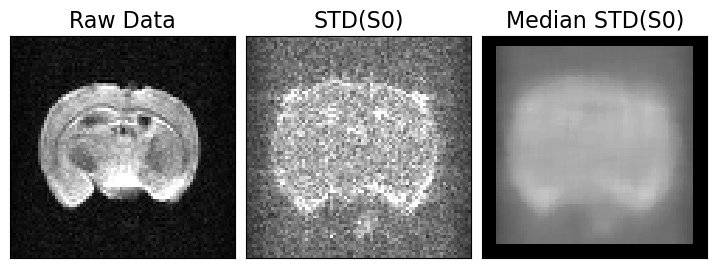

In [9]:
fig1, ax = plt.subplots(1, 3, figsize=(9, 3),
                        subplot_kw={'xticks': [], 'yticks': []})

fig1.subplots_adjust(hspace=0.03, wspace=0.05)
cax0 = ax.flat[0].imshow(orig.T/refval*100,
                  origin='lower', cmap='gray',
                  vmin=0, vmax=50, interpolation='nearest')
ax.flat[0].set_title('Raw Data', fontsize=16)


cax1 = ax.flat[1].imshow(stdS01[:, -1:0:-1, sli].T/refval*100,
                  origin='lower', cmap='gray',
                  vmin=0, vmax=3, interpolation='nearest')
ax.flat[1].set_title('STD(S0)', fontsize=16)


cax2 = ax.flat[2].imshow(stdS01_m[:, -1:0:-1, sli].T/refval*100,
                  origin='lower', cmap='gray',
                  vmin=0, vmax=3, interpolation='nearest')
ax.flat[2].set_title('Median STD(S0)', fontsize=16)

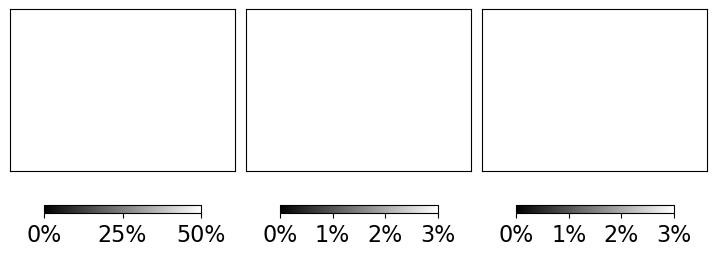

In [10]:
fig1, axs = plt.subplots(1, 3, figsize=(9, 3), constrained_layout=False,
                        subplot_kw={'xticks': [], 'yticks': []})
fig1.subplots_adjust(hspace=0.03, wspace=0.05)

cbar = fig1.colorbar(cax0, ax=[axs[0]], location='bottom', shrink=0.7, ticks=[0, 25, 50])
cbar.ax.set_xticklabels(['0%', '25%', '50%'])
cbar.ax.tick_params(labelsize=16) 

cbar = fig1.colorbar(cax1, ax=[axs[1]], location='bottom', shrink=0.7, ticks=[0, 1, 2, 3])
cbar.ax.set_xticklabels(['0%', '1%', '2%', '3%'])
cbar.ax.tick_params(labelsize=16) 

cbar = fig1.colorbar(cax2, ax=[axs[2]], location='bottom', shrink=0.7, ticks=[0, 1, 2, 3])
cbar.ax.set_xticklabels(['0%', '1%', '2%', '3%'])
cbar.ax.tick_params(labelsize=16) 


# Denoise data (dataset 1)

To speed the code let's only denoise a slice.

In [11]:
sel_slice1 = np.zeros(stdS01.shape)
sel_slice1[:, :, sli] = 1

sel_mask2 = np.zeros(stdS01.shape)
sel_mask2[:, :, sli] = mask1[:, :, sli]

In [12]:
m = (2*pr[0] + 1) * (2*pr[1] + 1) * (2*pr[2] + 1)
n = gtab.bvals.size
tau_factor = 1 + np.sqrt(n / m)

In [27]:
t = time()

den_mp1, sig_mp1, nc_mp1 = genpca(data1, mask=sel_slice1, patch_radius=pr,
                                  return_sigma=True)

print("Time taken for MPPCA ", -t + time())

C:\Users\rafae\AppData\Local\Temp\ipykernel_30776\2040020005.py:347: DeprecationWarning: Keyword argument 'turbo' is deprecated in favour of 'driver=gvd' keyword instead and will be removed in SciPy 1.12.0.
  [d, W] = eigh(C, turbo=True)


Time taken for MPPCA  39.41509461402893


C:\Users\rafae\AppData\Local\Temp\ipykernel_30776\2040020005.py:386: RuntimeWarning: invalid value encountered in divide
  denoised_arr = thetax / theta
C:\Users\rafae\AppData\Local\Temp\ipykernel_30776\2040020005.py:389: RuntimeWarning: invalid value encountered in divide
  ncall = ncall / thetavar
C:\Users\rafae\AppData\Local\Temp\ipykernel_30776\2040020005.py:392: RuntimeWarning: invalid value encountered in divide
  out_sigma = out_sigma / thetavar


In [28]:
t = time()

den_mp1_slow, sig_mp1_slow, nc_mp1_slow = genpca(data1, mppca_slow=True, mask=sel_slice1, patch_radius=pr,
                                                 return_sigma=True)

print("Time taken for MPPCA ", -t + time())

C:\Users\rafae\AppData\Local\Temp\ipykernel_30776\2040020005.py:347: DeprecationWarning: Keyword argument 'turbo' is deprecated in favour of 'driver=gvd' keyword instead and will be removed in SciPy 1.12.0.
  [d, W] = eigh(C, turbo=True)
C:\Users\rafae\AppData\Local\Temp\ipykernel_30776\2040020005.py:134: RuntimeWarning: divide by zero encountered in double_scalars
  nb_vall[ii] = (2*ro_mean - ro_var) / (h[ii]**2)


Time taken for MPPCA  2322.575676202774


C:\Users\rafae\AppData\Local\Temp\ipykernel_30776\2040020005.py:386: RuntimeWarning: invalid value encountered in divide
  denoised_arr = thetax / theta
C:\Users\rafae\AppData\Local\Temp\ipykernel_30776\2040020005.py:389: RuntimeWarning: invalid value encountered in divide
  ncall = ncall / thetavar
C:\Users\rafae\AppData\Local\Temp\ipykernel_30776\2040020005.py:392: RuntimeWarning: invalid value encountered in divide
  out_sigma = out_sigma / thetavar


In [29]:
t = time()

den_ht1, sig_ht1, nc_ht1 = genpca(data1, mask=sel_slice1, patch_radius=pr,
                                  sigma = stdS01_m, tau_factor=tau_factor,
                                  return_sigma=True)   

print("Time taken for TPCA", -t + time())

C:\Users\rafae\AppData\Local\Temp\ipykernel_30776\2040020005.py:347: DeprecationWarning: Keyword argument 'turbo' is deprecated in favour of 'driver=gvd' keyword instead and will be removed in SciPy 1.12.0.
  [d, W] = eigh(C, turbo=True)


Time taken for TPCA 30.515588521957397


C:\Users\rafae\AppData\Local\Temp\ipykernel_30776\2040020005.py:386: RuntimeWarning: invalid value encountered in divide
  denoised_arr = thetax / theta
C:\Users\rafae\AppData\Local\Temp\ipykernel_30776\2040020005.py:389: RuntimeWarning: invalid value encountered in divide
  ncall = ncall / thetavar
C:\Users\rafae\AppData\Local\Temp\ipykernel_30776\2040020005.py:392: RuntimeWarning: invalid value encountered in divide
  out_sigma = out_sigma / thetavar


In [30]:
t = time()

den_hv1, sig_hv1, nc_hv1 = genpca(data1, mask=sel_slice1, patch_radius=pr,
                                  sigma = stdS01_m, return_sigma=True)

print("Time taken for GPCA", -t + time())

C:\Users\rafae\AppData\Local\Temp\ipykernel_30776\2040020005.py:347: DeprecationWarning: Keyword argument 'turbo' is deprecated in favour of 'driver=gvd' keyword instead and will be removed in SciPy 1.12.0.
  [d, W] = eigh(C, turbo=True)


Time taken for GPCA 30.11861276626587


C:\Users\rafae\AppData\Local\Temp\ipykernel_30776\2040020005.py:386: RuntimeWarning: invalid value encountered in divide
  denoised_arr = thetax / theta
C:\Users\rafae\AppData\Local\Temp\ipykernel_30776\2040020005.py:389: RuntimeWarning: invalid value encountered in divide
  ncall = ncall / thetavar
C:\Users\rafae\AppData\Local\Temp\ipykernel_30776\2040020005.py:392: RuntimeWarning: invalid value encountered in divide
  out_sigma = out_sigma / thetavar


Plot denoised data

MPPCA
GPCA
TPCA
MPPCA slow


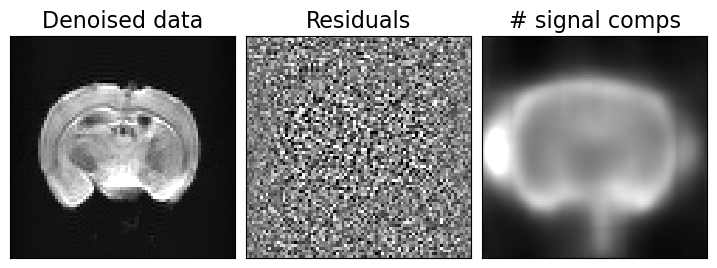

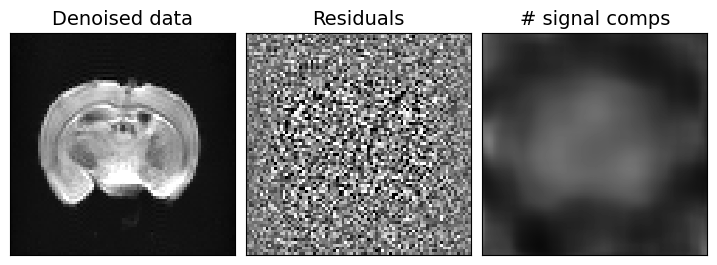

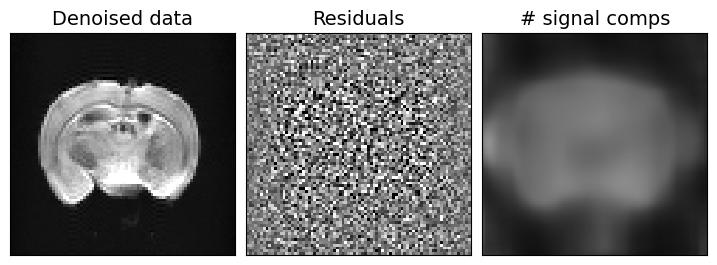

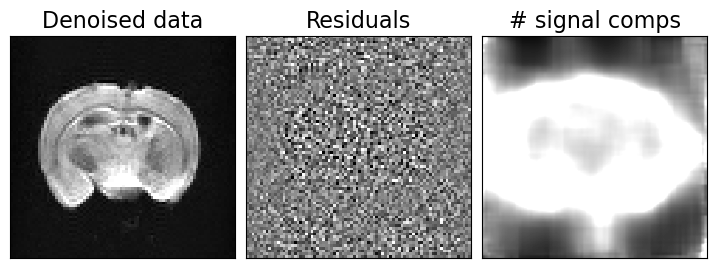

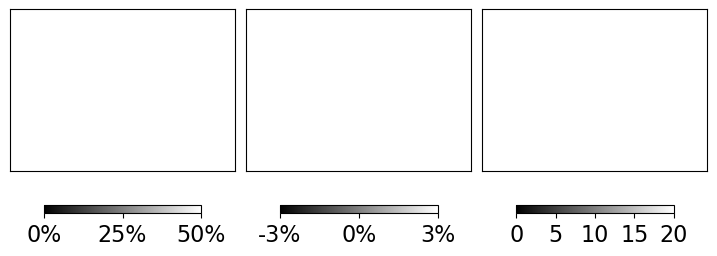

In [31]:
fig1, ax = plt.subplots(1, 3, figsize=(9, 3),
                        subplot_kw={'xticks': [], 'yticks': []})
fig1.subplots_adjust(hspace=0.03, wspace=0.05)

print('MPPCA')
den = den_mp1[:, -1:0:-1, sli, gra]
nc = nc_mp1[:, -1:0:-1, sli]
residuals = (orig - den)

cax0 = ax.flat[0].imshow(den.T/refval*100, cmap='gray', interpolation='none',
                  origin='lower', vmin=0, vmax=50)
ax.flat[0].set_title('Denoised data', fontsize=16)

cax1 = ax.flat[1].imshow(residuals.T/refval*100, cmap='gray', interpolation='none',
                  origin='lower', vmin=-3, vmax=3)
ax.flat[1].set_title('Residuals', fontsize=16)

cax2 = ax.flat[2].imshow(nc.T, cmap='gray',
                        origin='lower', vmin=0, vmax=20)
ax.flat[2].set_title('# signal comps', fontsize=16)
#cbar = plt.colorbar(cax, ax=ax.flat[2])
#cbar.ax.tick_params(labelsize=12)

print('GPCA')
fig1, ax = plt.subplots(1, 3, figsize=(9, 3),
                        subplot_kw={'xticks': [], 'yticks': []})
fig1.subplots_adjust(hspace=0.03, wspace=0.05)

den = den_hv1[:, -1:0:-1, sli, gra]
nc = nc_hv1[:, -1:0:-1, sli]
residuals = (orig - den)

cax0 = ax.flat[0].imshow(den.T/refval*100, cmap='gray', interpolation='none',
                  origin='lower', vmin=0, vmax=50)
ax.flat[0].set_title('Denoised data', fontsize=14)

cax1 = ax.flat[1].imshow(residuals.T/refval*100, cmap='gray', interpolation='none',
                  origin='lower', vmin=-3, vmax=3)
ax.flat[1].set_title('Residuals', fontsize=14)

cax2 = ax.flat[2].imshow(nc.T, cmap='gray',
                        origin='lower', vmin=0, vmax=20)
ax.flat[2].set_title('# signal comps', fontsize=14)

# TPCA
print('TPCA')
fig1, ax = plt.subplots(1, 3, figsize=(9, 3),
                        subplot_kw={'xticks': [], 'yticks': []})
fig1.subplots_adjust(hspace=0.03, wspace=0.05)

den = den_ht1[:, -1:0:-1, sli, gra]
nc = nc_ht1[:, -1:0:-1, sli]
residuals = (orig - den)

cax0 = ax.flat[0].imshow(den.T/refval*100, cmap='gray', interpolation='none',
                  origin='lower', vmin=0, vmax=50)
ax.flat[0].set_title('Denoised data', fontsize=14)

cax1 = ax.flat[1].imshow(residuals.T/refval*100, cmap='gray', interpolation='none',
                  origin='lower', vmin=-3, vmax=3)
ax.flat[1].set_title('Residuals', fontsize=14)

cax2 = ax.flat[2].imshow(nc.T, cmap='gray',
                        origin='lower', vmin=0, vmax=20)
ax.flat[2].set_title('# signal comps', fontsize=14)

print('MPPCA slow')

fig1, ax = plt.subplots(1, 3, figsize=(9, 3),
                        subplot_kw={'xticks': [], 'yticks': []})
fig1.subplots_adjust(hspace=0.03, wspace=0.05)

den = den_mp1_slow[:, -1:0:-1, sli, gra]
nc = nc_mp1_slow[:, -1:0:-1, sli]
residuals = (orig - den)

cax0 = ax.flat[0].imshow(den.T/refval*100, cmap='gray', interpolation='none',
                  origin='lower', vmin=0, vmax=50)
ax.flat[0].set_title('Denoised data', fontsize=16)

cax1 = ax.flat[1].imshow(residuals.T/refval*100, cmap='gray', interpolation='none',
                  origin='lower', vmin=-3, vmax=3)
ax.flat[1].set_title('Residuals', fontsize=16)

cax2 = ax.flat[2].imshow(nc.T, cmap='gray',
                        origin='lower', vmin=0, vmax=20)
ax.flat[2].set_title('# signal comps', fontsize=16)
#cbar = plt.colorbar(cax, ax=ax.flat[2])
#cbar.ax.tick_params(labelsize=12)


# colorbars

fig1, axs = plt.subplots(1, 3, figsize=(9, 3), constrained_layout=False,
                        subplot_kw={'xticks': [], 'yticks': []})
fig1.subplots_adjust(hspace=0.03, wspace=0.05)

cbar = fig1.colorbar(cax0, ax=[axs[0]], location='bottom', shrink=0.7, ticks=[0, 25, 50])
cbar.ax.set_xticklabels(['0%', '25%', '50%'])
cbar.ax.tick_params(labelsize=16) 

cbar = fig1.colorbar(cax1, ax=[axs[1]], location='bottom', shrink=0.7, ticks=[-3, 0, 3])
cbar.ax.set_xticklabels(['-3%', '0%', '3%'])
cbar.ax.tick_params(labelsize=16) 

cbar = fig1.colorbar(cax2, ax=[axs[2]], location='bottom', shrink=0.7, ticks=[0, 5, 10, 15, 20])
cbar.ax.set_xticklabels(['0', '5', '10', '15', '20'])
cbar.ax.tick_params(labelsize=16) 


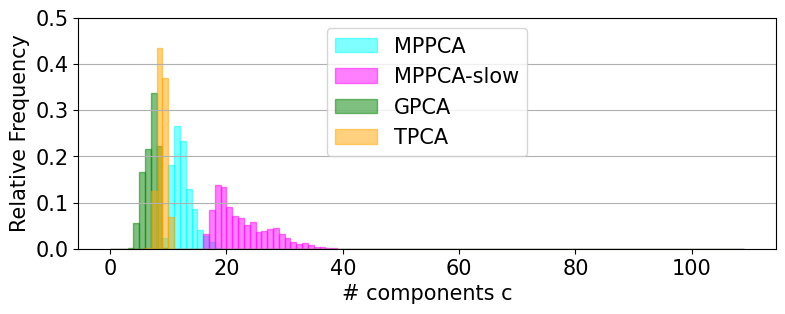

In [32]:
plt.rcParams.update({'font.size': 15})

fig1, ax = plt.subplots(1, 1, figsize=(9, 3))
bins = np.arange(0, 110, 1)
counts, ed = np.histogram(nc_mp1[sel_mask2==1], bins=bins, density=True)
cax0 = ax.bar(ed[:-1]+np.diff(ed[:2])/2, counts, width = 1, color='cyan', alpha=0.5, edgecolor='cyan', label='MPPCA')

counts, ed = np.histogram(nc_mp1_slow[sel_mask2==1], bins=bins, density=True)
cax0 = ax.bar(ed[:-1]+np.diff(ed[:2])/2, counts, width = 1, color='magenta', alpha=0.5, edgecolor='magenta', label='MPPCA-slow')

counts, ed = np.histogram(nc_hv1[sel_mask2==1], bins=bins, density=True)
cax0 = ax.bar(ed[:-1]+np.diff(ed[:2])/2, counts, width = 1, color='green', alpha=0.5, edgecolor='green', label='GPCA')

counts, ed = np.histogram(nc_ht1[sel_mask2==1], bins=bins, density=True)
cax0 = ax.bar(ed[:-1]+np.diff(ed[:2])/2, counts, width = 1, color='orange', alpha=0.5, edgecolor='orange', label='TPCA')

plt.grid(axis='y', alpha=1)
plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
plt.xlabel('# components c')
plt.ylabel('Relative Frequency')

plt.legend(loc=9, prop={'size': 15})

# Estimate noise STD and SNR (dataset 2)

In [33]:
S0s = data2[:, :, :, gtab.b0s_mask]
stdS02 = np.std(S0s, axis=-1)
meanS0 = np.mean(S0s, axis=-1)

stdS02_m = median_filt(stdS02, patch_radius=pr)

In [34]:
# plot maps as a reference of the mean value of brain voxels at b=0
flat_mask = mask2.flatten()
flat_mS0 = meanS0.flatten()
refval = np.mean(flat_mS0[flat_mask==1])

# select representative axial image
sli = 4

# select representative diffusion-weighted data
gra = 22  # pick out a volume for a high b-value
print(gtab.bvals[gra])
orig = data2[:, -1:0:-1, sli, gra]

3006.942


Text(0.5, 1.0, 'Median STD(S0)')

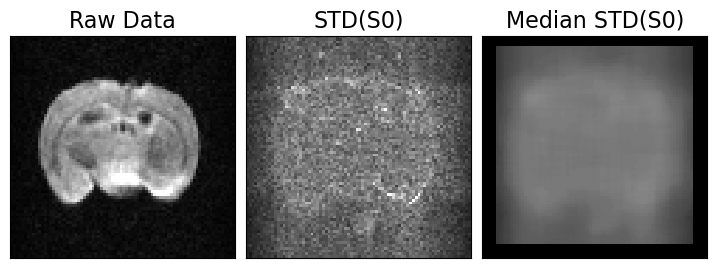

In [35]:
fig1, ax = plt.subplots(1, 3, figsize=(9, 3),
                        subplot_kw={'xticks': [], 'yticks': []})

fig1.subplots_adjust(hspace=0.03, wspace=0.05)
cax0 = ax.flat[0].imshow(orig.T/refval*100,
                  origin='lower', cmap='gray',
                  vmin=0, vmax=50, interpolation='none')
ax.flat[0].set_title('Raw Data', fontsize=16)


cax1 = ax.flat[1].imshow(stdS02[:, -1:0:-1, sli].T/refval*100,
                  origin='lower', cmap='gray',
                  vmin=0, vmax=3, interpolation='none')
ax.flat[1].set_title('STD(S0)', fontsize=16)


cax2 = ax.flat[2].imshow(stdS02_m[:, -1:0:-1, sli].T/refval*100,
                  origin='lower', cmap='gray',
                  vmin=0, vmax=3, interpolation='none')
ax.flat[2].set_title('Median STD(S0)', fontsize=16)

# Denoise data (dataset 2)

In [36]:
sel_slice2 = np.zeros(stdS02.shape)
sel_slice2[:, :, sli] = 1

sel_mask2 = np.zeros(stdS02.shape)
sel_mask2[:, :, sli] = mask2[:, :, sli]

In [37]:
m = (2*pr[0] + 1) * (2*pr[1] + 1) * (2*pr[2] + 1)
n = gtab.bvals.size
tau_factor = 1 + np.sqrt(n / m)

In [38]:
t = time()

den_mp2, sig_mp2, nc_mp2 = genpca(data2, mask=sel_slice2, patch_radius=pr,
                                  return_sigma=True)

print("Time taken for MP-PCA ", -t + time())

C:\Users\rafae\AppData\Local\Temp\ipykernel_30776\2040020005.py:347: DeprecationWarning: Keyword argument 'turbo' is deprecated in favour of 'driver=gvd' keyword instead and will be removed in SciPy 1.12.0.
  [d, W] = eigh(C, turbo=True)


Time taken for MP-PCA  37.20283007621765


C:\Users\rafae\AppData\Local\Temp\ipykernel_30776\2040020005.py:386: RuntimeWarning: invalid value encountered in divide
  denoised_arr = thetax / theta
C:\Users\rafae\AppData\Local\Temp\ipykernel_30776\2040020005.py:389: RuntimeWarning: invalid value encountered in divide
  ncall = ncall / thetavar
C:\Users\rafae\AppData\Local\Temp\ipykernel_30776\2040020005.py:392: RuntimeWarning: invalid value encountered in divide
  out_sigma = out_sigma / thetavar


In [39]:
t = time()

den_mp2_slow, sig_mp2_slow, nc_mp2_slow = genpca(data2, mppca_slow=True, mask=sel_slice2,
                                                 patch_radius=pr, return_sigma=True)

print("Time taken for MP-PCA ", -t + time())

C:\Users\rafae\AppData\Local\Temp\ipykernel_30776\2040020005.py:347: DeprecationWarning: Keyword argument 'turbo' is deprecated in favour of 'driver=gvd' keyword instead and will be removed in SciPy 1.12.0.
  [d, W] = eigh(C, turbo=True)
C:\Users\rafae\AppData\Local\Temp\ipykernel_30776\2040020005.py:134: RuntimeWarning: divide by zero encountered in double_scalars
  nb_vall[ii] = (2*ro_mean - ro_var) / (h[ii]**2)


Time taken for MP-PCA  2447.151635169983


C:\Users\rafae\AppData\Local\Temp\ipykernel_30776\2040020005.py:386: RuntimeWarning: invalid value encountered in divide
  denoised_arr = thetax / theta
C:\Users\rafae\AppData\Local\Temp\ipykernel_30776\2040020005.py:389: RuntimeWarning: invalid value encountered in divide
  ncall = ncall / thetavar
C:\Users\rafae\AppData\Local\Temp\ipykernel_30776\2040020005.py:392: RuntimeWarning: invalid value encountered in divide
  out_sigma = out_sigma / thetavar


In [40]:
t = time()


den_ht2, sig_ht2, nc_ht2 = genpca(data2, mask=sel_slice2, patch_radius=pr,
                                  sigma = stdS02_m, tau_factor=tau_factor,
                                  return_sigma=True)

print("Time taken for TPCA t", -t + time())

C:\Users\rafae\AppData\Local\Temp\ipykernel_30776\2040020005.py:347: DeprecationWarning: Keyword argument 'turbo' is deprecated in favour of 'driver=gvd' keyword instead and will be removed in SciPy 1.12.0.
  [d, W] = eigh(C, turbo=True)


Time taken for TPCA t 29.604675769805908


C:\Users\rafae\AppData\Local\Temp\ipykernel_30776\2040020005.py:386: RuntimeWarning: invalid value encountered in divide
  denoised_arr = thetax / theta
C:\Users\rafae\AppData\Local\Temp\ipykernel_30776\2040020005.py:389: RuntimeWarning: invalid value encountered in divide
  ncall = ncall / thetavar
C:\Users\rafae\AppData\Local\Temp\ipykernel_30776\2040020005.py:392: RuntimeWarning: invalid value encountered in divide
  out_sigma = out_sigma / thetavar


In [41]:
t = time()

den_hv2, sig_hv2, nc_hv2 = genpca(data2, mask=sel_slice2, patch_radius=pr,
                                  sigma = stdS02_m, return_sigma=True)

print("Time taken for GPCA v", -t + time())

C:\Users\rafae\AppData\Local\Temp\ipykernel_30776\2040020005.py:347: DeprecationWarning: Keyword argument 'turbo' is deprecated in favour of 'driver=gvd' keyword instead and will be removed in SciPy 1.12.0.
  [d, W] = eigh(C, turbo=True)


Time taken for GPCA v 30.145087957382202


C:\Users\rafae\AppData\Local\Temp\ipykernel_30776\2040020005.py:386: RuntimeWarning: invalid value encountered in divide
  denoised_arr = thetax / theta
C:\Users\rafae\AppData\Local\Temp\ipykernel_30776\2040020005.py:389: RuntimeWarning: invalid value encountered in divide
  ncall = ncall / thetavar
C:\Users\rafae\AppData\Local\Temp\ipykernel_30776\2040020005.py:392: RuntimeWarning: invalid value encountered in divide
  out_sigma = out_sigma / thetavar


MPPCA
GPCA
TPCA
MPPCA slow


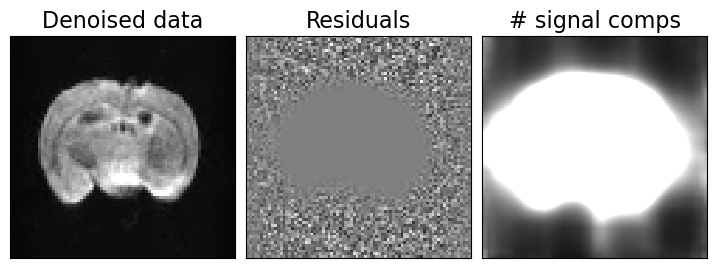

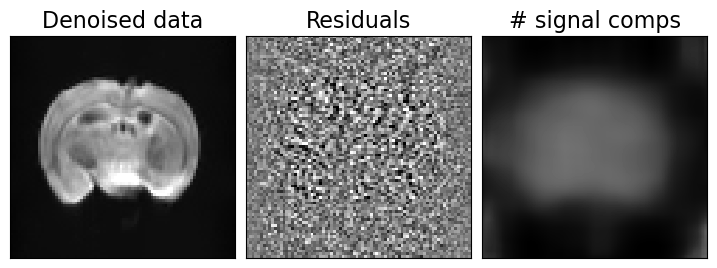

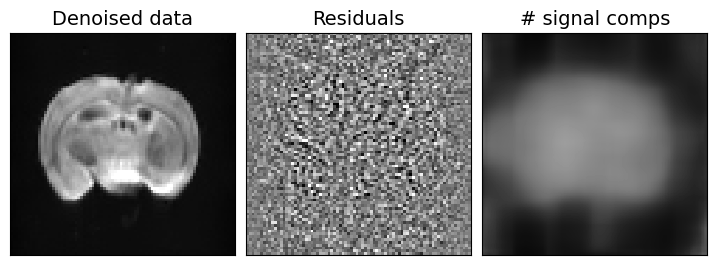

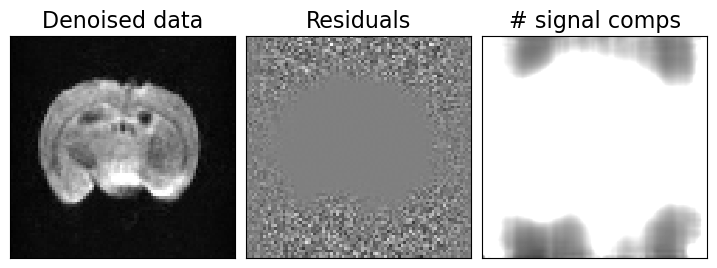

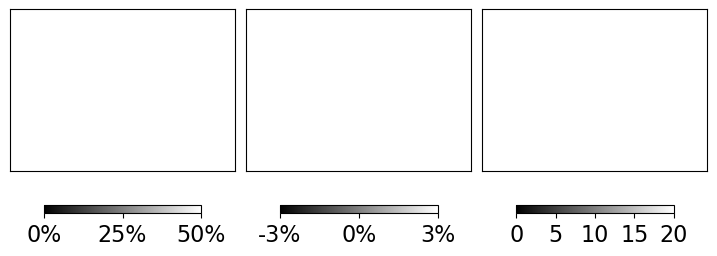

In [42]:
fig1, ax = plt.subplots(1, 3, figsize=(9, 3),
                        subplot_kw={'xticks': [], 'yticks': []})
fig1.subplots_adjust(hspace=0.03, wspace=0.05)

print('MPPCA')
den = den_mp2[:, -1:0:-1, sli, gra]
nc = nc_mp2[:, -1:0:-1, sli]
residuals = (orig - den)

cax0 = ax.flat[0].imshow(den.T/refval*100, cmap='gray', interpolation='none',
                  origin='lower', vmin=0, vmax=50)
ax.flat[0].set_title('Denoised data', fontsize=16)

cax1 = ax.flat[1].imshow(residuals.T/refval*100, cmap='gray', interpolation='none',
                  origin='lower', vmin=-3, vmax=3)
ax.flat[1].set_title('Residuals', fontsize=16)

cax2 = ax.flat[2].imshow(nc.T, cmap='gray',
                        origin='lower', vmin=0, vmax=20)
ax.flat[2].set_title('# signal comps', fontsize=16)
#cbar = plt.colorbar(cax, ax=ax.flat[2])
#cbar.ax.tick_params(labelsize=12)

print('GPCA')
fig1, ax = plt.subplots(1, 3, figsize=(9, 3),
                        subplot_kw={'xticks': [], 'yticks': []})
fig1.subplots_adjust(hspace=0.03, wspace=0.05)

den = den_hv2[:, -1:0:-1, sli, gra]
nc = nc_hv2[:, -1:0:-1, sli]
residuals = (orig - den)

cax0 = ax.flat[0].imshow(den.T/refval*100, cmap='gray', interpolation='none',
                  origin='lower', vmin=0, vmax=50)
ax.flat[0].set_title('Denoised data', fontsize=16)

cax1 = ax.flat[1].imshow(residuals.T/refval*100, cmap='gray', interpolation='none',
                  origin='lower', vmin=-3, vmax=3)
ax.flat[1].set_title('Residuals', fontsize=16)

cax2 = ax.flat[2].imshow(nc.T, cmap='gray',
                        origin='lower', vmin=0, vmax=20)
ax.flat[2].set_title('# signal comps', fontsize=16)

# TPCA
print('TPCA')
fig1, ax = plt.subplots(1, 3, figsize=(9, 3),
                        subplot_kw={'xticks': [], 'yticks': []})
fig1.subplots_adjust(hspace=0.03, wspace=0.05)

den = den_ht2[:, -1:0:-1, sli, gra]
nc = nc_ht2[:, -1:0:-1, sli]
residuals = (orig - den)

cax0 = ax.flat[0].imshow(den.T/refval*100, cmap='gray', interpolation='none',
                  origin='lower', vmin=0, vmax=50)
ax.flat[0].set_title('Denoised data', fontsize=14)

cax1 = ax.flat[1].imshow(residuals.T/refval*100, cmap='gray', interpolation='none',
                  origin='lower', vmin=-3, vmax=3)
ax.flat[1].set_title('Residuals', fontsize=14)

cax2 = ax.flat[2].imshow(nc.T, cmap='gray',
                        origin='lower', vmin=0, vmax=20)
ax.flat[2].set_title('# signal comps', fontsize=14)


print('MPPCA slow')
fig1, ax = plt.subplots(1, 3, figsize=(9, 3),
                        subplot_kw={'xticks': [], 'yticks': []})
fig1.subplots_adjust(hspace=0.03, wspace=0.05)

den = den_mp2_slow[:, -1:0:-1, sli, gra]
nc = nc_mp2_slow[:, -1:0:-1, sli]
residuals = (orig - den)

cax0 = ax.flat[0].imshow(den.T/refval*100, cmap='gray', interpolation='none',
                  origin='lower', vmin=0, vmax=50)
ax.flat[0].set_title('Denoised data', fontsize=16)

cax1 = ax.flat[1].imshow(residuals.T/refval*100, cmap='gray', interpolation='none',
                  origin='lower', vmin=-3, vmax=3)
ax.flat[1].set_title('Residuals', fontsize=16)

cax2 = ax.flat[2].imshow(nc.T, cmap='gray',
                        origin='lower', vmin=0, vmax=20)
ax.flat[2].set_title('# signal comps', fontsize=16)
#cbar = plt.colorbar(cax, ax=ax.flat[2])
#cbar.ax.tick_params(labelsize=12)


# colorbars

fig1, axs = plt.subplots(1, 3, figsize=(9, 3), constrained_layout=False,
                        subplot_kw={'xticks': [], 'yticks': []})
fig1.subplots_adjust(hspace=0.03, wspace=0.05)

cbar = fig1.colorbar(cax0, ax=[axs[0]], location='bottom', shrink=0.7, ticks=[0, 25, 50])
cbar.ax.set_xticklabels(['0%', '25%', '50%'])
cbar.ax.tick_params(labelsize=16) 

cbar = fig1.colorbar(cax1, ax=[axs[1]], location='bottom', shrink=0.7, ticks=[-3, 0, 3])
cbar.ax.set_xticklabels(['-3%', '0%', '3%'])
cbar.ax.tick_params(labelsize=16) 

cbar = fig1.colorbar(cax2, ax=[axs[2]], location='bottom', shrink=0.7, ticks=[0, 5, 10, 15, 20])
cbar.ax.set_xticklabels(['0', '5', '10', '15', '20'])
cbar.ax.tick_params(labelsize=16) 


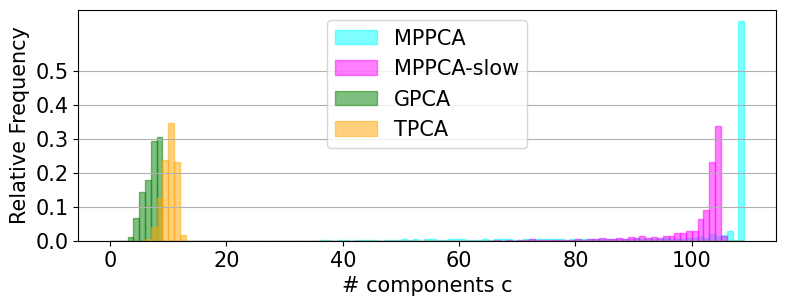

In [43]:
plt.rcParams.update({'font.size': 15})

fig1, ax = plt.subplots(1, 1, figsize=(9, 3))
bins = np.arange(0, 110, 1)
counts, ed = np.histogram(nc_mp2[sel_mask2==1], bins=bins, density=True)
cax0 = ax.bar(ed[:-1]+np.diff(ed[:2])/2, counts, width = 1, color='cyan', alpha=0.5, edgecolor='cyan', label='MPPCA')

counts, ed = np.histogram(nc_mp2_slow[sel_mask2==1], bins=bins, density=True)
cax0 = ax.bar(ed[:-1]+np.diff(ed[:2])/2, counts, width = 1, color='magenta', alpha=0.5, edgecolor='magenta', label='MPPCA-slow')

counts, ed = np.histogram(nc_hv2[sel_mask2==1], bins=bins, density=True)
cax0 = ax.bar(ed[:-1]+np.diff(ed[:2])/2, counts, width = 1, color='green', alpha=0.5, edgecolor='green', label='GPCA')

counts, ed = np.histogram(nc_ht2[sel_mask2==1], bins=bins, density=True)
cax0 = ax.bar(ed[:-1]+np.diff(ed[:2])/2, counts, width = 1, color='orange', alpha=0.5, edgecolor='orange', label='TPCA')

plt.grid(axis='y', alpha=1)
plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
plt.xlabel('# components c')
plt.ylabel('Relative Frequency')

plt.legend(loc=9, prop={'size': 15})

# DKI fit

In [44]:
dkim = DiffusionKurtosisModel(gtab)

dki_r1 = dkim.fit(data1, mask=mask1)
dki_r2 = dkim.fit(data2, mask=mask2)

dki_mp1 = dkim.fit(den_mp1, mask=mask1)
dki_mp2 = dkim.fit(den_mp2, mask=mask2)

dki_mp1_slow = dkim.fit(den_mp1_slow, mask=mask1)
dki_mp2_slow = dkim.fit(den_mp2_slow, mask=mask2)

dki_hv1 = dkim.fit(den_hv1, mask=mask1)
dki_hv2 = dkim.fit(den_hv2, mask=mask2)

dki_ht1 = dkim.fit(den_ht1, mask=mask1)
dki_ht2 = dkim.fit(den_ht2, mask=mask2)

100%|████████████████████████████████████████████████████████████████████████| 15895/15895.0 [00:13<00:00, 1203.11it/s]
100%|████████████████████████████████████████████████████████████████████████| 15710/15710.0 [00:14<00:00, 1075.57it/s]
100%|████████████████████████████████████████████████████████████████████████| 15895/15895.0 [00:13<00:00, 1220.43it/s]
100%|████████████████████████████████████████████████████████████████████████| 15710/15710.0 [00:13<00:00, 1134.13it/s]
100%|████████████████████████████████████████████████████████████████████████| 15895/15895.0 [00:13<00:00, 1184.52it/s]
100%|████████████████████████████████████████████████████████████████████████| 15710/15710.0 [00:12<00:00, 1229.95it/s]
100%|████████████████████████████████████████████████████████████████████████| 15895/15895.0 [00:13<00:00, 1215.71it/s]
100%|████████████████████████████████████████████████████████████████████████| 15710/15710.0 [00:13<00:00, 1200.48it/s]
100%|███████████████████████████████████

In [45]:
# Fit the gold standard for dataset2
data2_gs, affine = load_nifti(path + 'MB_exp2_20averages.nii')
dki_gs = dkim.fit(data2_gs, mask=mask2)

100%|████████████████████████████████████████████████████████████████████████| 15710/15710.0 [00:14<00:00, 1090.24it/s]


In [46]:
# MD
MD1 = dki_r1.md
MD2 = dki_r2.md

MD_mp1 = dki_mp1.md
MD_mp2 = dki_mp2.md

MD_mp1_slow = dki_mp1_slow.md
MD_mp2_slow = dki_mp2_slow.md

MD_ht1 = dki_ht1.md
MD_ht2 = dki_ht2.md

MD_hv1 = dki_hv1.md
MD_hv2 = dki_hv2.md

MD_gs = dki_gs.md

# AD
AD1 = dki_r1.ad
AD2 = dki_r2.ad

AD_mp1 = dki_mp1.ad
AD_mp2 = dki_mp2.ad

AD_mp1_slow = dki_mp1_slow.ad
AD_mp2_slow = dki_mp2_slow.ad

AD_ht1 = dki_ht1.ad
AD_ht2 = dki_ht2.ad

AD_hv1 = dki_hv1.ad
AD_hv2 = dki_hv2.ad

AD_gs = dki_gs.ad

# RD
RD1 = dki_r1.rd
RD2 = dki_r2.rd

RD_mp1 = dki_mp1.rd
RD_mp2 = dki_mp2.rd

RD_mp1_slow = dki_mp1_slow.rd
RD_mp2_slow = dki_mp2_slow.rd

RD_ht1 = dki_ht1.rd
RD_ht2 = dki_ht2.rd

RD_hv1 = dki_hv1.rd
RD_hv2 = dki_hv2.rd

RD_gs = dki_gs.rd

# FA
FA1 = dki_r1.fa
FA2 = dki_r2.fa

FA_mp1 = dki_mp1.fa
FA_mp2 = dki_mp2.fa

FA_mp1_slow = dki_mp1_slow.fa
FA_mp2_slow = dki_mp2_slow.fa

FA_ht1 = dki_ht1.fa
FA_ht2 = dki_ht2.fa

FA_hv1 = dki_hv1.fa
FA_hv2 = dki_hv2.fa

FA_gs = dki_gs.fa

# MK
MK1 = dki_r1.mk(0, 10, analytical=False)
MK2 = dki_r2.mk(0, 10, analytical=False)

MK_mp1 = dki_mp1.mk(0, 10, analytical=False)
MK_mp2 = dki_mp2.mk(0, 10, analytical=False) 

MK_mp1_slow = dki_mp1_slow.mk(0, 10, analytical=False)
MK_mp2_slow = dki_mp2_slow.mk(0, 10, analytical=False) 

MK_ht1 = dki_ht1.mk(0, 10, analytical=False)
MK_ht2 = dki_ht2.mk(0, 10, analytical=False) 

MK_hv1 = dki_hv1.mk(0, 10, analytical=False)
MK_hv2 = dki_hv2.mk(0, 10, analytical=False) 

MK_gs = dki_gs.mk(0, 10, analytical=False) 

# AK
AK1 = dki_r1.ak(0, 10, analytical=False)
AK2 = dki_r2.ak(0, 10, analytical=False)

AK_mp1 = dki_mp1.ak(0, 10, analytical=False)
AK_mp2 = dki_mp2.ak(0, 10, analytical=False)

AK_mp1_slow = dki_mp1_slow.ak(0, 10, analytical=False)
AK_mp2_slow = dki_mp2_slow.ak(0, 10, analytical=False) 

AK_ht1 = dki_ht1.ak(0, 10, analytical=False)
AK_ht2 = dki_ht2.ak(0, 10, analytical=False)

AK_hv1 = dki_hv1.ak(0, 10, analytical=False)
AK_hv2 = dki_hv2.ak(0, 10, analytical=False)

AK_gs = dki_gs.ak(0, 10, analytical=False) 

# RK
RK1 = dki_r1.rk(0, 10, analytical=False)
RK2 = dki_r2.rk(0, 10, analytical=False)

RK_mp1 = dki_mp1.rk(0, 10, analytical=False)
RK_mp2 = dki_mp2.rk(0, 10, analytical=False) 

RK_mp1_slow = dki_mp1_slow.rk(0, 10, analytical=False)
RK_mp2_slow = dki_mp2_slow.rk(0, 10, analytical=False) 

RK_ht1 = dki_ht1.rk(0, 10, analytical=False)
RK_ht2 = dki_ht2.rk(0, 10, analytical=False)

RK_hv1 = dki_hv1.rk(0, 10, analytical=False)
RK_hv2 = dki_hv2.rk(0, 10, analytical=False)

RK_gs = dki_gs.rk(0, 10, analytical=False) 

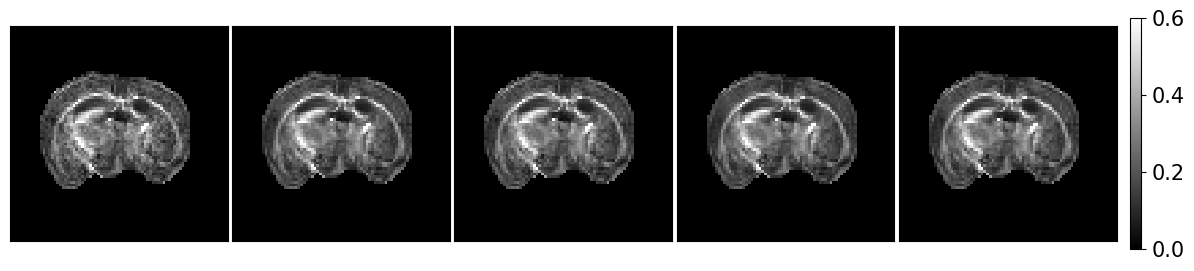

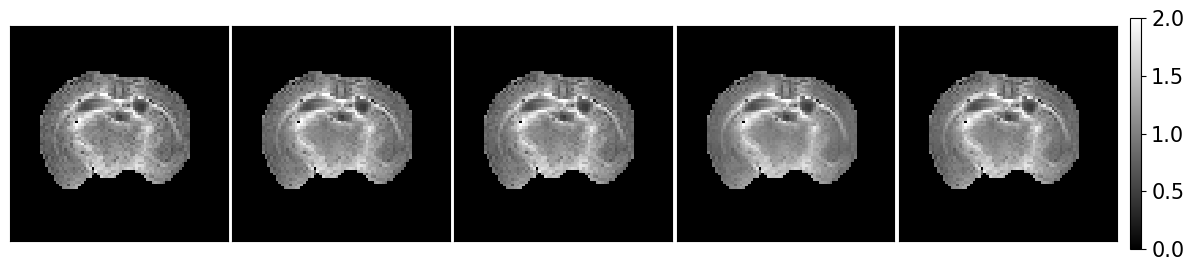

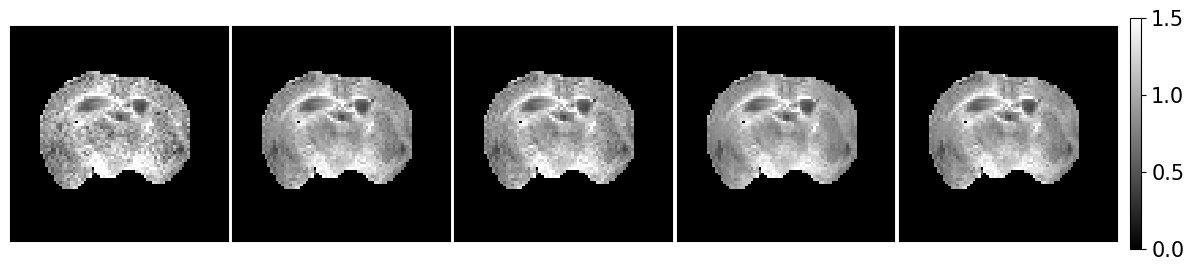

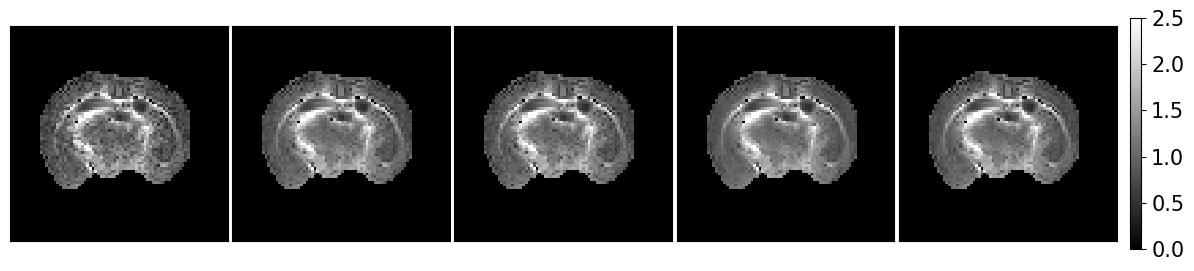

In [47]:
#### dataset1 plots
########################## FA #####################################

fig2, ax = plt.subplots(1, 5, figsize=(17, 3),
                        subplot_kw={'xticks': [], 'yticks': []})
fig2.subplots_adjust(hspace=0.01, wspace=0.02)

MD =  FA1[:, -1:0:-1, sli]
immd = ax.flat[0].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=0.6, origin='lower')

MD =  FA_mp1[:, -1:0:-1, sli]
immd = ax.flat[1].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=0.6, origin='lower')

MD =  FA_mp1_slow[:, -1:0:-1, sli]
immd = ax.flat[2].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=0.6, origin='lower')

MD =  FA_hv1[:, -1:0:-1, sli]
immd = ax.flat[3].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=0.6, origin='lower')

MD =  FA_ht1[:, -1:0:-1, sli]
immd = ax.flat[4].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=0.6, origin='lower')

fig2.colorbar(immd, ax=ax.flat[:], pad=0.01)

########################## MK #####################################

fig2, ax = plt.subplots(1, 5, figsize=(17, 3),
                        subplot_kw={'xticks': [], 'yticks': []})
fig2.subplots_adjust(hspace=0.01, wspace=0.02)

MD =  MK1[:, -1:0:-1, sli]
immd = ax.flat[0].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=2, origin='lower')

MD =  MK_mp1[:, -1:0:-1, sli]
immd = ax.flat[1].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=2, origin='lower')

MD =  MK_mp1_slow[:, -1:0:-1, sli]
immd = ax.flat[2].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=2, origin='lower')

MD =  MK_hv1[:, -1:0:-1, sli]
immd = ax.flat[3].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=2, origin='lower')

MD =  MK_ht1[:, -1:0:-1, sli]
immd = ax.flat[4].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=2, origin='lower')

fig2.colorbar(immd, ax=ax.flat[:], pad=0.01)

########################## AK #####################################

fig2, ax = plt.subplots(1, 5, figsize=(17, 3),
                        subplot_kw={'xticks': [], 'yticks': []})
fig2.subplots_adjust(hspace=0.01, wspace=0.02)

MD =  AK1[:, -1:0:-1, sli]
immd = ax.flat[0].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=1.5, origin='lower')

MD =  AK_mp1[:, -1:0:-1, sli]
immd = ax.flat[1].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=1.5, origin='lower')

MD =  AK_mp1_slow[:, -1:0:-1, sli]
immd = ax.flat[2].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=1.5, origin='lower')

MD =  AK_hv1[:, -1:0:-1, sli]
immd = ax.flat[3].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=1.5, origin='lower')

MD =  AK_ht1[:, -1:0:-1, sli]
immd = ax.flat[4].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=1.5, origin='lower')

fig2.colorbar(immd, ax=ax.flat[:], pad=0.01)

########################## RK #####################################

fig2, ax = plt.subplots(1, 5, figsize=(17, 3),
                        subplot_kw={'xticks': [], 'yticks': []})
fig2.subplots_adjust(hspace=0.01, wspace=0.02)

MD =  RK1[:, -1:0:-1, sli]
immd = ax.flat[0].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=2.5, origin='lower')

MD =  RK_mp1[:, -1:0:-1, sli]
immd = ax.flat[1].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=2.5, origin='lower')

MD =  RK_mp1_slow[:, -1:0:-1, sli]
immd = ax.flat[2].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=2.5, origin='lower')

MD =  RK_hv1[:, -1:0:-1, sli]
immd = ax.flat[3].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=2.5, origin='lower')

MD =  RK_ht1[:, -1:0:-1, sli]
immd = ax.flat[4].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=2.5, origin='lower')

fig2.colorbar(immd, ax=ax.flat[:], pad=0.01)

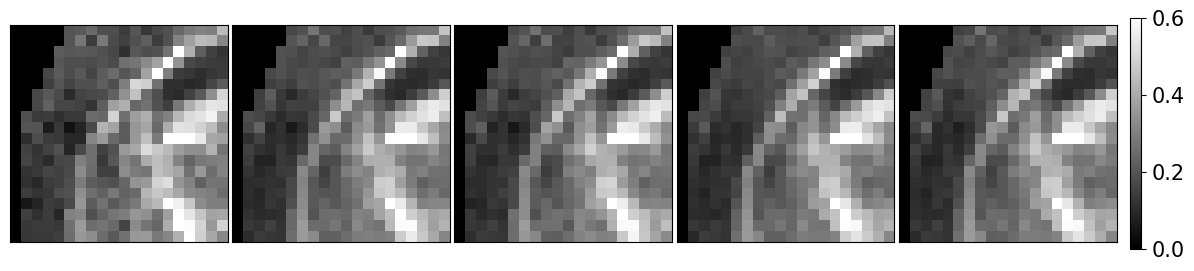

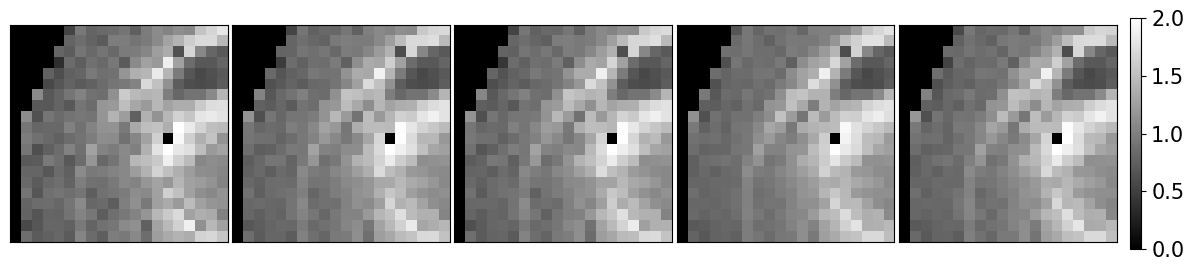

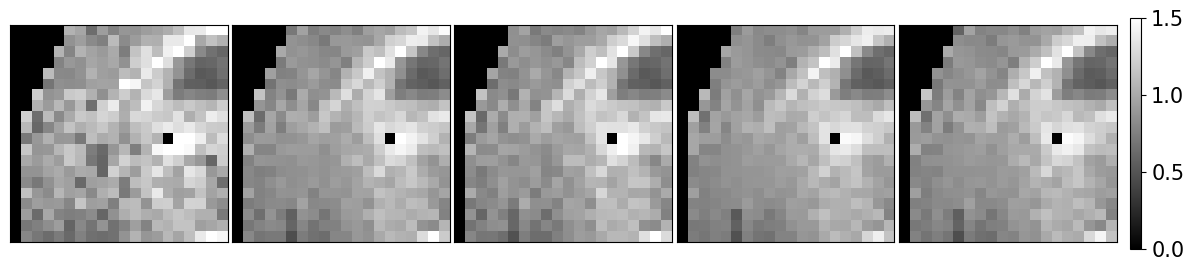

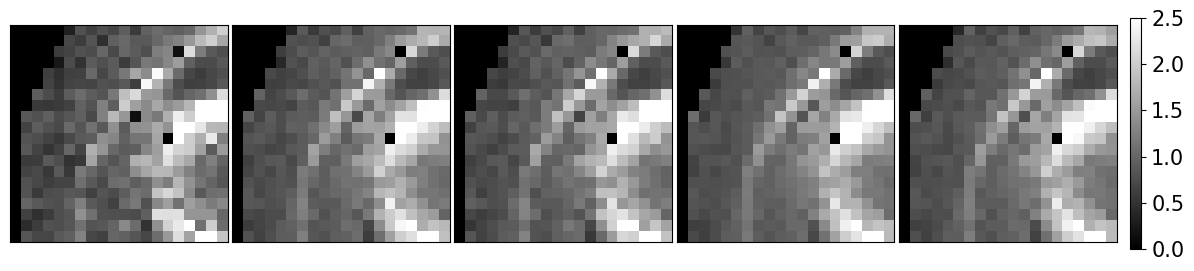

In [48]:
#### dataset1 zoom plots
########################## FA #####################################

xiii = 10
xfff = 30
yiii = 34
yfff = 54

fig2, ax = plt.subplots(1, 5, figsize=(17, 3),
                        subplot_kw={'xticks': [], 'yticks': []})
fig2.subplots_adjust(hspace=0.01, wspace=0.02)

MD =  FA1[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[0].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=0.6, origin='lower')

MD =  FA_mp1[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[1].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=0.6, origin='lower')

MD =  FA_mp1_slow[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[2].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=0.6, origin='lower')

MD =  FA_hv1[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[3].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=0.6, origin='lower')

MD =  FA_ht1[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[4].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=0.6, origin='lower')

fig2.colorbar(immd, ax=ax.flat[:], pad=0.01)

########################## MK #####################################

fig2, ax = plt.subplots(1, 5, figsize=(17, 3),
                        subplot_kw={'xticks': [], 'yticks': []})
fig2.subplots_adjust(hspace=0.01, wspace=0.02)

MD =  MK1[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[0].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=2, origin='lower')

MD =  MK_mp1[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[1].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=2, origin='lower')

MD =  MK_mp1_slow[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[2].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=2, origin='lower')

MD =  MK_hv1[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[3].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=2, origin='lower')

MD =  MK_ht1[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[4].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=2, origin='lower')

fig2.colorbar(immd, ax=ax.flat[:], pad=0.01)

########################## AK #####################################

fig2, ax = plt.subplots(1, 5, figsize=(17, 3),
                        subplot_kw={'xticks': [], 'yticks': []})
fig2.subplots_adjust(hspace=0.01, wspace=0.02)

MD =  AK1[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[0].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=1.5, origin='lower')

MD =  AK_mp1[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[1].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=1.5, origin='lower')

MD =  AK_mp1_slow[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[2].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=1.5, origin='lower')

MD =  AK_hv1[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[3].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=1.5, origin='lower')

MD =  AK_ht1[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[4].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=1.5, origin='lower')

fig2.colorbar(immd, ax=ax.flat[:], pad=0.01)

########################## RK #####################################

fig2, ax = plt.subplots(1, 5, figsize=(17, 3),
                        subplot_kw={'xticks': [], 'yticks': []})
fig2.subplots_adjust(hspace=0.01, wspace=0.02)

MD =  RK1[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[0].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=2.5, origin='lower')

MD =  RK_mp1[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[1].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=2.5, origin='lower')

MD =  RK_mp1_slow[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[2].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=2.5, origin='lower')

MD =  RK_hv1[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[3].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=2.5, origin='lower')

MD =  RK_ht1[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[4].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=2.5, origin='lower')

fig2.colorbar(immd, ax=ax.flat[:], pad=0.01)

# Check if residuals are Gaussian

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109]
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109


Text(0.5, 0, 'r')

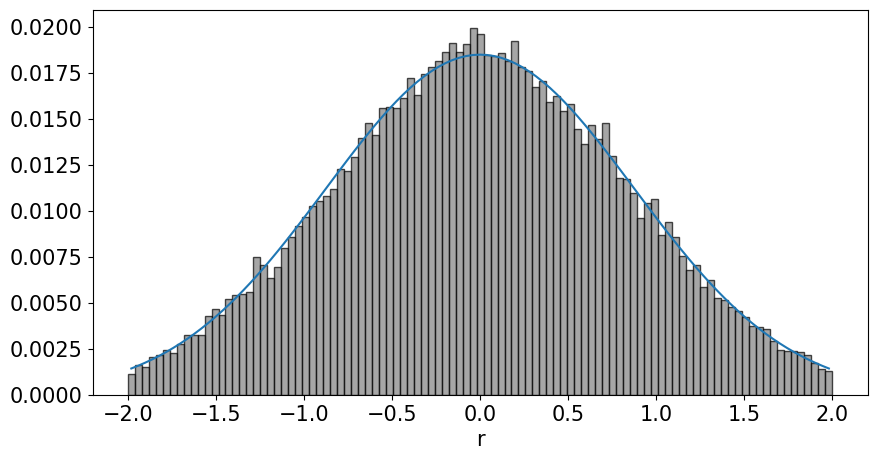

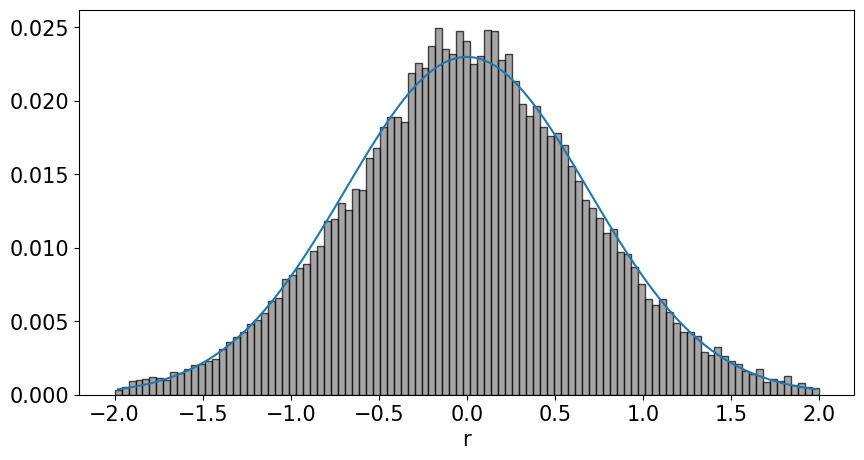

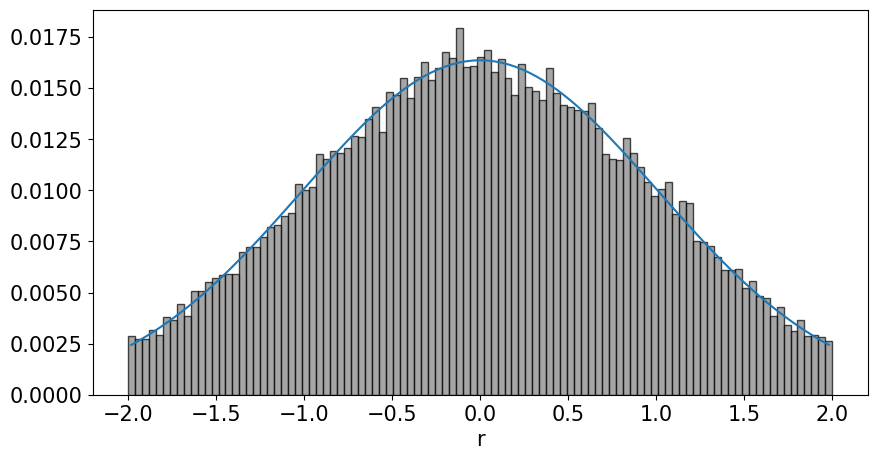

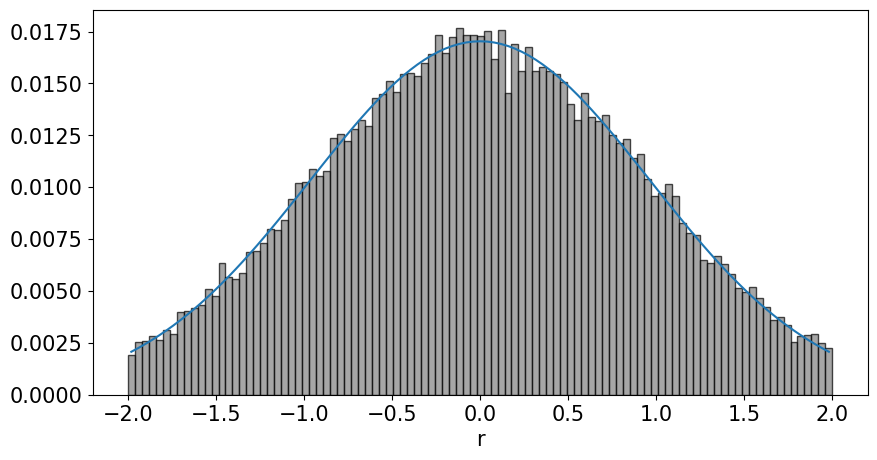

In [49]:
vols = np.arange(0, gtab.bvals.size)
vols_sel = vols[gtab.bvals > -1]
print(vols_sel)

# select portion of the data (important because STD is spatially variant)
roi = np.zeros((80, 79))
# region shown in Figure 4
xiii = 10
xfff = 30
yiii = 34
yfff = 54
roi[xiii:xfff, yiii:yfff] = 1

Rmp1_all = den_mp1 - data1
Rmp1_slow_all = den_mp1_slow - data1
Rht1_all = den_ht1 - data1
Rhv1_all = den_hv1 - data1

Rmp1 = Rmp1_all[:, -1:0:-1, sli, vols_sel[0]]
Rmp1_slow = Rmp1_slow_all[:, -1:0:-1, sli, vols_sel[0]]
Rht1 = Rht1_all[:, -1:0:-1, sli, vols_sel[0]]
Rhv1 = Rhv1_all[:, -1:0:-1, sli, vols_sel[0]]

Rmp1_vec = Rmp1[roi==1]
Rmp1_slow_vec = Rmp1_slow[roi==1]
Rht1_vec = Rht1[roi==1]
Rhv1_vec = Rhv1[roi==1]

for vi in range(1, vols_sel.size):
    Rmp1 = Rmp1_all[:, -1:0:-1, sli, vols_sel[vi]]
    Rmp1_slow = Rmp1_slow_all[:, -1:0:-1, sli, vols_sel[vi]]
    Rht1 = Rht1_all[:, -1:0:-1, sli, vols_sel[vi]]
    Rhv1 = Rhv1_all[:, -1:0:-1, sli, vols_sel[vi]]
    Rmp1_vec = np.append(Rmp1_vec, Rmp1[roi==1])
    Rmp1_slow_vec = np.append(Rmp1_slow_vec, Rmp1_slow[roi==1])
    Rht1_vec = np.append(Rht1_vec, Rht1[roi==1])
    Rhv1_vec = np.append(Rhv1_vec, Rhv1[roi==1])
    print(vi)

sffmp1 = np.std(Rmp1_vec)
sffmp1_slow = np.std(Rmp1_slow_vec)
sffht1 = np.std(Rht1_vec)
sffhv1 = np.std(Rhv1_vec)

rpos = 2
rneg = -2
nb = 101

x = np.linspace(rneg, rpos, num=nb)

# Reference 
prefmp1 = np.exp(-1/2 * (x/sffmp1)**2)
prefmp1 = prefmp1 / np.sum(prefmp1)

prefmp1_slow = np.exp(-1/2 * (x/sffmp1_slow)**2)
prefmp1_slow = prefmp1_slow / np.sum(prefmp1_slow)

prefht1 = np.exp(-1/2 * (x/sffht1)**2)
prefht1 = prefht1 / np.sum(prefht1)

prefhv1 = np.exp(-1/2 * (x/sffhv1)**2)
prefhv1 = prefhv1 / np.sum(prefhv1)

# Bins
beig, ed = np.histogram(Rmp1_vec, bins = nb, range=(rneg, rpos))
beig_mp1 = beig / np.sum(beig)

beig, ed = np.histogram(Rmp1_slow_vec, bins = nb, range=(rneg, rpos))
beig_mp1_slow = beig / np.sum(beig)

beig, ed = np.histogram(Rhv1_vec, bins = nb, range=(rneg, rpos))
beig_hv1 = beig / np.sum(beig)

beig, ed = np.histogram(Rht1_vec, bins = nb, range=(rneg, rpos))
beig_ht1 = beig / np.sum(beig)


fig = plt.figure(figsize=(10, 5))
plt.bar(ed[:-1]+(rpos-rneg)/(2*nb), beig_mp1, width = (rpos-rneg)/nb, color='grey', alpha=0.7, edgecolor='black', label='measured dist.')
plt.plot(ed[:-1]+(rpos-rneg)/(2*nb), prefmp1)
plt.xlabel('r', fontsize=15)

fig = plt.figure(figsize=(10, 5))
plt.bar(ed[:-1]+(rpos-rneg)/(2*nb), beig_mp1_slow, width = (rpos-rneg)/nb, color='grey', alpha=0.7, edgecolor='black', label='measured dist.')
plt.plot(ed[:-1]+(rpos-rneg)/(2*nb), prefmp1_slow)
plt.xlabel('r', fontsize=15)

fig = plt.figure(figsize=(10, 5))
plt.bar(ed[:-1]+(rpos-rneg)/(2*nb), beig_hv1, width = (rpos-rneg)/nb, color='grey', alpha=0.7, edgecolor='black', label='measured dist.')
plt.plot(ed[:-1]+(rpos-rneg)/(2*nb), prefhv1)
plt.xlabel('r', fontsize=15)

fig = plt.figure(figsize=(10, 5))
plt.bar(ed[:-1]+(rpos-rneg)/(2*nb), beig_ht1, width = (rpos-rneg)/nb, color='grey', alpha=0.7, edgecolor='black', label='measured dist.')
plt.plot(ed[:-1]+(rpos-rneg)/(2*nb), prefht1)
plt.xlabel('r', fontsize=15)


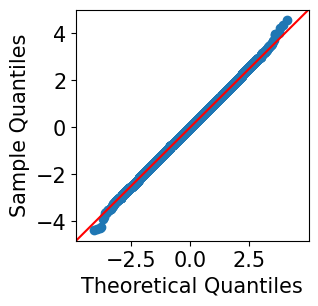

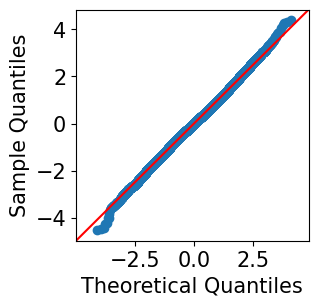

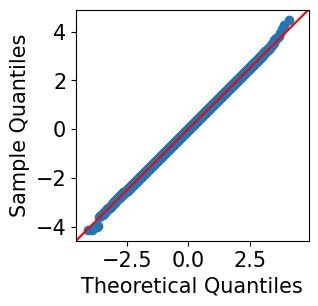

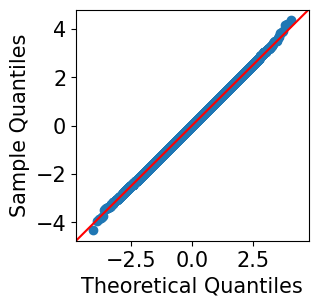

In [50]:
import matplotlib as mpl

with mpl.rc_context():
    mpl.rc("figure", figsize=(3, 3))
    sm.qqplot(Rmp1_vec, line='45', fit=True)
    pylab.show()
    sm.qqplot(Rmp1_slow_vec, line='45', fit=True)
    pylab.show()
    sm.qqplot(Rht1_vec, line='45', fit=True)
    pylab.show()
    sm.qqplot(Rhv1_vec, line='45', fit=True)
    pylab.show()


### Plot DKI results for dataset 2 (with Gold standard)

[Text(1, 0.0, '0'), Text(1, 0.3, '0.3'), Text(1, 0.6, '0.6')]

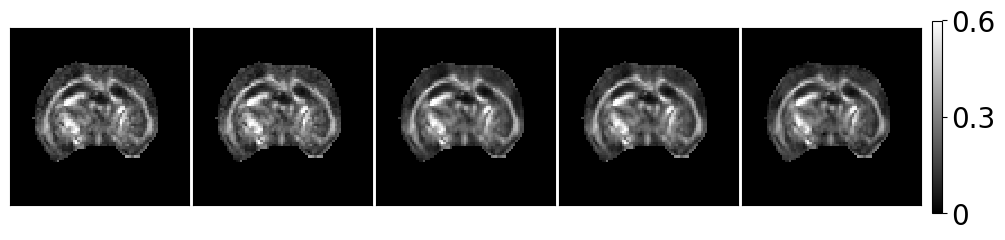

In [51]:
#### zoom plots
########################## FA #####################################
plt.rcParams.update({'font.size': 20})
fig2, ax = plt.subplots(1, 5, figsize=(14, 2.5),
                        subplot_kw={'xticks': [], 'yticks': []})
fig2.subplots_adjust(hspace=0.01, wspace=0.02)

MD =  FA2[:, -1:0:-1, sli]

immd = ax.flat[0].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=0.6, origin='lower')

MD =  FA_mp2[:, -1:0:-1, sli]
immd = ax.flat[1].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=0.6, origin='lower')

MD =  FA_ht2[:, -1:0:-1, sli]
immd = ax.flat[3].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=0.6, origin='lower')

MD =  FA_hv2[:, -1:0:-1, sli]
immd = ax.flat[2].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=0.6, origin='lower')

MD =  FA_gs[:, -1:0:-1, sli]
immd = ax.flat[4].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=0.6, origin='lower')
cbar = fig2.colorbar(immd, ax=ax.flat[:], ticks=[0, 0.3, 0.6], pad=0.01)
cbar.ax.set_yticklabels(['0', '0.3', '0.6'])

[Text(1, -0.15, '-0.15'), Text(1, 0.0, '0'), Text(1, 0.15, '0.15')]

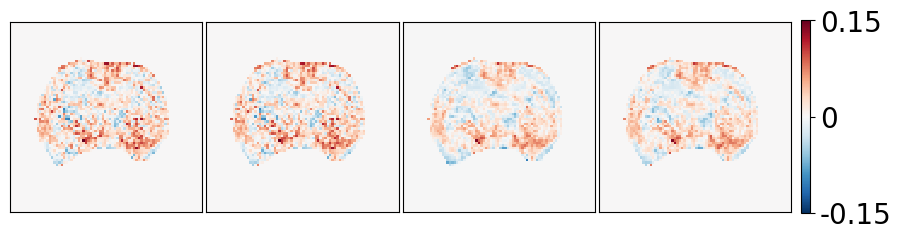

In [52]:
#### zoom plots
########################## FA #####################################
plt.rcParams.update({'font.size': 20})
fig2, ax = plt.subplots(1, 4, figsize=(12, 2.5),
                        subplot_kw={'xticks': [], 'yticks': []})
fig2.subplots_adjust(hspace=0.01, wspace=0.02)

MD =  FA2[:, -1:0:-1, sli] - FA_gs[:, -1:0:-1, sli]

immd = ax.flat[0].imshow(MD.T, cmap='RdBu_r', interpolation='none',
                         vmin=-0.15, vmax=0.15, origin='lower')

MD =  FA_mp2[:, -1:0:-1, sli] - FA_gs[:, -1:0:-1, sli]
immd = ax.flat[1].imshow(MD.T, cmap='RdBu_r', interpolation='none',
                         vmin=-0.15, vmax=0.15, origin='lower')

MD =  FA_ht2[:, -1:0:-1, sli] - FA_gs[:, -1:0:-1, sli]
immd = ax.flat[3].imshow(MD.T, cmap='RdBu_r', interpolation='none',
                         vmin=-0.15, vmax=0.15, origin='lower')

MD =  FA_hv2[:, -1:0:-1, sli] - FA_gs[:, -1:0:-1, sli]
immd = ax.flat[2].imshow(MD.T, cmap='RdBu_r', interpolation='none',
                         vmin=-0.15, vmax=0.15, origin='lower')

cbar = fig2.colorbar(immd, ax=ax.flat[:], ticks=[-0.15, 0.0, 0.15], pad=0.01)
cbar.ax.set_yticklabels(['-0.15', '0', '0.15'])

[Text(1, 0.0, '0'), Text(1, 0.3, '0.3'), Text(1, 0.6, '0.6')]

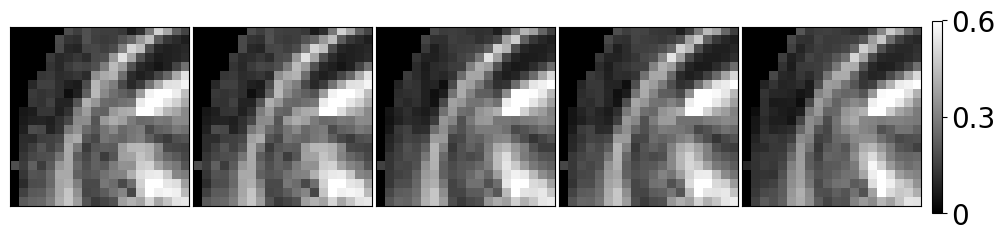

In [53]:
#### zoom plots
########################## FA #####################################

fig2, ax = plt.subplots(1, 5, figsize=(14, 2.5),
                        subplot_kw={'xticks': [], 'yticks': []})
fig2.subplots_adjust(hspace=0.01, wspace=0.02)

MD =  FA2[:, -1:0:-1, sli]
xiii = 10
xfff = 30
yiii = 34
yfff = 54
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[0].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=0.6, origin='lower')

MD =  FA_mp2[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[1].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=0.6, origin='lower')

MD =  FA_ht2[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[3].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=0.6, origin='lower')

MD =  FA_hv2[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[2].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=0.6, origin='lower')

MD =  FA_gs[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[4].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=0.6, origin='lower')
cbar = fig2.colorbar(immd, ax=ax.flat[:], ticks=[0, 0.3, 0.6], pad=0.01)
cbar.ax.set_yticklabels(['0', '0.3', '0.6'])


[Text(1, -0.15, '-0.15'), Text(1, 0.0, '0'), Text(1, 0.15, '0.15')]

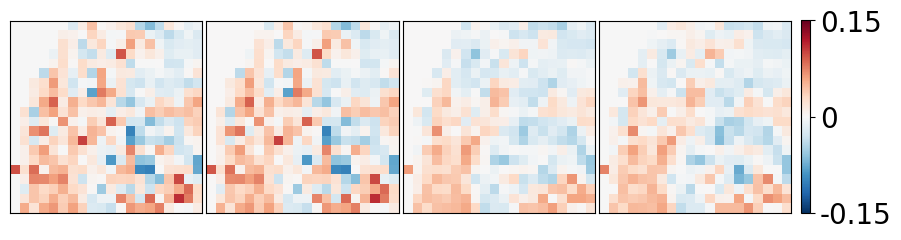

In [54]:
#### zoom plots
########################## FA #####################################
plt.rcParams.update({'font.size': 20})
fig2, ax = plt.subplots(1, 4, figsize=(12, 2.5),
                        subplot_kw={'xticks': [], 'yticks': []})
fig2.subplots_adjust(hspace=0.01, wspace=0.02)

MD =  FA2[:, -1:0:-1, sli] - FA_gs[:, -1:0:-1, sli]
xiii = 10
xfff = 30
yiii = 34
yfff = 54
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[0].imshow(MD.T, cmap='RdBu_r', interpolation='none',
                         vmin=-0.15, vmax=0.15, origin='lower')

MD =  FA_mp2[:, -1:0:-1, sli] - FA_gs[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[1].imshow(MD.T, cmap='RdBu_r', interpolation='none',
                         vmin=-0.15, vmax=0.15, origin='lower')

MD =  FA_ht2[:, -1:0:-1, sli] - FA_gs[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[3].imshow(MD.T, cmap='RdBu_r', interpolation='none',
                         vmin=-0.15, vmax=0.15, origin='lower')

MD =  FA_hv2[:, -1:0:-1, sli] - FA_gs[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[2].imshow(MD.T, cmap='RdBu_r', interpolation='none',
                         vmin=-0.15, vmax=0.15, origin='lower')

cbar = fig2.colorbar(immd, ax=ax.flat[:], ticks=[-0.15, 0.0, 0.15], pad=0.01)
cbar.ax.set_yticklabels(['-0.15', '0', '0.15'])

[Text(1, 0, '0'), Text(1, 1, '1.0'), Text(1, 2, '2.0')]

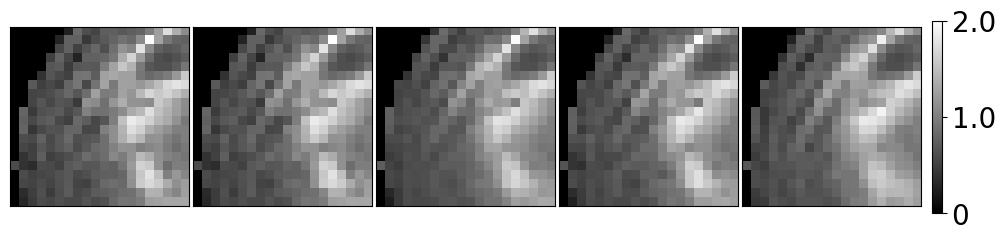

In [55]:
#### zoom plots
########################## FA #####################################

fig2, ax = plt.subplots(1, 5, figsize=(14, 2.5),
                        subplot_kw={'xticks': [], 'yticks': []})
fig2.subplots_adjust(hspace=0.01, wspace=0.02)

MD =  MK2[:, -1:0:-1, sli]
xiii = 10
xfff = 30
yiii = 34
yfff = 54
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[0].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=2, origin='lower')

MD =  MK_mp2[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[1].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=2, origin='lower')

MD =  MK_ht2[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[3].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=2, origin='lower')

MD =  MK_hv2[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[2].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=2, origin='lower')

MD =  MK_gs[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[4].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=2, origin='lower')
cbar = fig2.colorbar(immd, ax=ax.flat[:], ticks=[0, 1, 2], pad=0.01)
cbar.ax.set_yticklabels(['0', '1.0', '2.0'])

[Text(1, -0.3, '-0.3'), Text(1, 0.0, '0'), Text(1, 0.3, '0.3')]

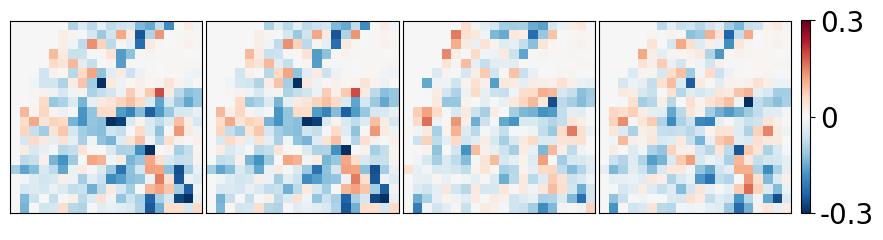

In [56]:
#### zoom plots
########################## FA #####################################

fig2, ax = plt.subplots(1, 4, figsize=(12, 2.5),
                        subplot_kw={'xticks': [], 'yticks': []})
fig2.subplots_adjust(hspace=0.01, wspace=0.02)

MD =  MK2[:, -1:0:-1, sli] - MK_gs[:, -1:0:-1, sli]
xiii = 10
xfff = 30
yiii = 34
yfff = 54
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[0].imshow(MD.T, cmap='RdBu_r', interpolation='none',
                         vmin=-0.3, vmax=0.3, origin='lower')

MD =  MK_mp2[:, -1:0:-1, sli] - MK_gs[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[1].imshow(MD.T, cmap='RdBu_r', interpolation='none',
                         vmin=-0.3, vmax=0.3, origin='lower')

MD =  MK_ht2[:, -1:0:-1, sli] - MK_gs[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[3].imshow(MD.T, cmap='RdBu_r', interpolation='none',
                         vmin=-0.3, vmax=0.3, origin='lower')

MD =  MK_hv2[:, -1:0:-1, sli] - MK_gs[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[2].imshow(MD.T, cmap='RdBu_r', interpolation='none',
                         vmin=-0.3, vmax=0.3, origin='lower')


cbar = fig2.colorbar(immd, ax=ax.flat[:], ticks=[-0.3, 0, 0.3], pad=0.01)
cbar.ax.set_yticklabels(['-0.3', '0', '0.3'])

[Text(1, 0.0, '0'), Text(1, 1.2, '1.2'), Text(1, 2.4, '2.4')]

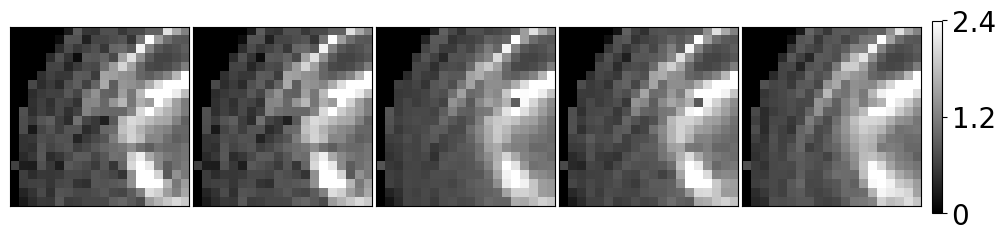

In [57]:
#### zoom plots
########################## FA #####################################

fig2, ax = plt.subplots(1, 5, figsize=(14, 2.5),
                        subplot_kw={'xticks': [], 'yticks': []})
fig2.subplots_adjust(hspace=0.01, wspace=0.02)

MD =  RK2[:, -1:0:-1, sli]
xiii = 10
xfff = 30
yiii = 34
yfff = 54
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[0].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=2.4, origin='lower')

MD =  RK_mp2[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[1].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=2.4, origin='lower')

MD =  RK_ht2[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[3].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=2.4, origin='lower')

MD =  RK_hv2[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[2].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=2.4, origin='lower')

MD =  RK_gs[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[4].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=2.4, origin='lower')
cbar = fig2.colorbar(immd, ax=ax.flat[:], ticks=[0, 1.2, 2.4], pad=0.01)
cbar.ax.set_yticklabels(['0', '1.2', '2.4'])

[Text(1, -0.4, '-0.4'), Text(1, 0.0, '0'), Text(1, 0.4, '0.4')]

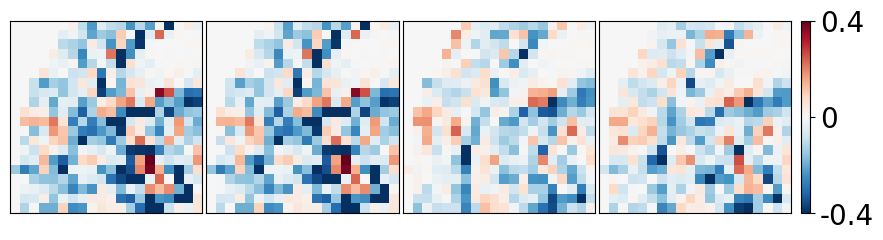

In [58]:
#### zoom plots
########################## FA #####################################

fig2, ax = plt.subplots(1, 4, figsize=(12, 2.5),
                        subplot_kw={'xticks': [], 'yticks': []})
fig2.subplots_adjust(hspace=0.01, wspace=0.02)

MD =  RK2[:, -1:0:-1, sli] - RK_gs[:, -1:0:-1, sli]
xiii = 10
xfff = 30
yiii = 34
yfff = 54
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[0].imshow(MD.T, cmap='RdBu_r', interpolation='none',
                         vmin=-0.4, vmax=0.4, origin='lower')

MD =  RK_mp2[:, -1:0:-1, sli] - RK_gs[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[1].imshow(MD.T, cmap='RdBu_r', interpolation='none',
                         vmin=-0.4, vmax=0.4, origin='lower')

MD =  RK_ht2[:, -1:0:-1, sli] - RK_gs[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[3].imshow(MD.T, cmap='RdBu_r', interpolation='none',
                         vmin=-0.4, vmax=0.4, origin='lower')

MD =  RK_hv2[:, -1:0:-1, sli] - RK_gs[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[2].imshow(MD.T, cmap='RdBu_r', interpolation='none',
                         vmin=-0.4, vmax=0.4, origin='lower')


cbar = fig2.colorbar(immd, ax=ax.flat[:], ticks=[-0.4, 0, 0.4], pad=0.01)
cbar.ax.set_yticklabels(['-0.4', '0', '0.4'])

[Text(1, 0.0, '0'), Text(1, 0.7, '0.7'), Text(1, 1.4, '1.4')]

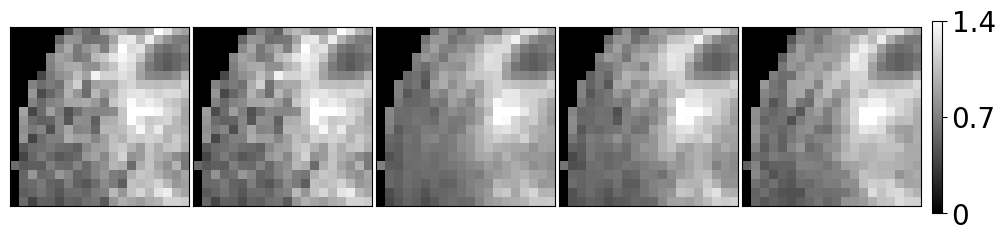

In [59]:
#### zoom plots
########################## FA #####################################

fig2, ax = plt.subplots(1, 5, figsize=(14, 2.5),
                        subplot_kw={'xticks': [], 'yticks': []})
fig2.subplots_adjust(hspace=0.01, wspace=0.02)

MD =  AK2[:, -1:0:-1, sli]
xiii = 10
xfff = 30
yiii = 34
yfff = 54
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[0].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=1.4, origin='lower')

MD =  AK_mp2[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[1].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=1.4, origin='lower')

MD =  AK_ht2[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[3].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=1.4, origin='lower')

MD =  AK_hv2[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[2].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=1.4, origin='lower')

MD =  AK_gs[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[4].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=1.4, origin='lower')
cbar = fig2.colorbar(immd, ax=ax.flat[:], ticks=[0, 0.7, 1.4], pad=0.01)
cbar.ax.set_yticklabels(['0', '0.7', '1.4'])

[Text(1, -0.4, '-0.4'), Text(1, 0.0, '0'), Text(1, 0.4, '0.4')]

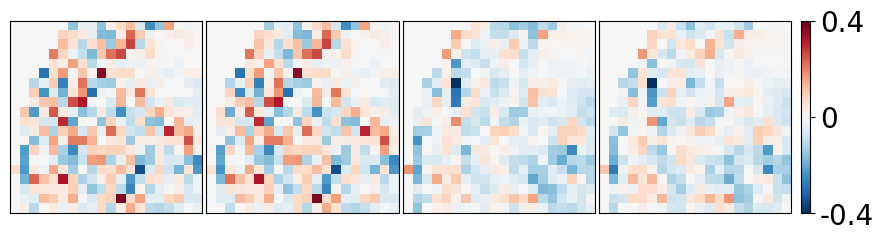

In [60]:
#### zoom plots
########################## FA #####################################

fig2, ax = plt.subplots(1, 4, figsize=(12, 2.5),
                        subplot_kw={'xticks': [], 'yticks': []})
fig2.subplots_adjust(hspace=0.01, wspace=0.02)

MD =  AK2[:, -1:0:-1, sli] - AK_gs[:, -1:0:-1, sli]
xiii = 10
xfff = 30
yiii = 34
yfff = 54
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[0].imshow(MD.T, cmap='RdBu_r', interpolation='none',
                         vmin=-0.4, vmax=0.4, origin='lower')

MD =  AK_mp2[:, -1:0:-1, sli] - AK_gs[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[1].imshow(MD.T, cmap='RdBu_r', interpolation='none',
                         vmin=-0.4, vmax=0.4, origin='lower')

MD =  AK_ht2[:, -1:0:-1, sli] - AK_gs[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[3].imshow(MD.T, cmap='RdBu_r', interpolation='none',
                         vmin=-0.4, vmax=0.4, origin='lower')

MD =  AK_hv2[:, -1:0:-1, sli] - AK_gs[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[2].imshow(MD.T, cmap='RdBu_r', interpolation='none',
                         vmin=-0.4, vmax=0.4, origin='lower')


cbar = fig2.colorbar(immd, ax=ax.flat[:], ticks=[-0.4, 0, 0.4], pad=0.01)
cbar.ax.set_yticklabels(['-0.4', '0', '0.4'])

# Plot DKI results for dataset 2 (with Gold standard, replacing MPPCA by MPPCA-slow)

[Text(1, 0.0, '0'), Text(1, 0.3, '0.3'), Text(1, 0.6, '0.6')]

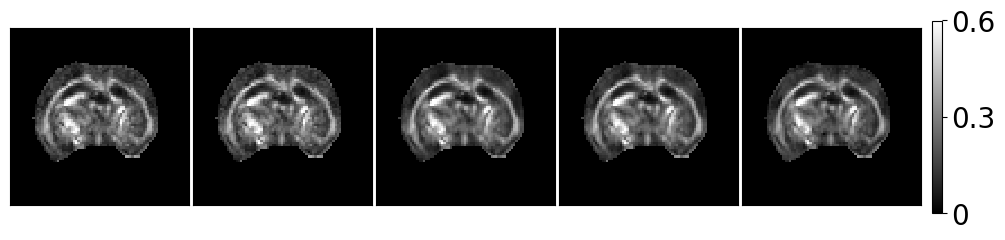

In [61]:
#### zoom plots
########################## FA #####################################
plt.rcParams.update({'font.size': 20})
fig2, ax = plt.subplots(1, 5, figsize=(14, 2.5),
                        subplot_kw={'xticks': [], 'yticks': []})
fig2.subplots_adjust(hspace=0.01, wspace=0.02)

MD =  FA2[:, -1:0:-1, sli]

immd = ax.flat[0].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=0.6, origin='lower')

MD =  FA_mp2_slow[:, -1:0:-1, sli]
immd = ax.flat[1].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=0.6, origin='lower')

MD =  FA_ht2[:, -1:0:-1, sli]
immd = ax.flat[3].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=0.6, origin='lower')

MD =  FA_hv2[:, -1:0:-1, sli]
immd = ax.flat[2].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=0.6, origin='lower')

MD =  FA_gs[:, -1:0:-1, sli]
immd = ax.flat[4].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=0.6, origin='lower')
cbar = fig2.colorbar(immd, ax=ax.flat[:], ticks=[0, 0.3, 0.6], pad=0.01)
cbar.ax.set_yticklabels(['0', '0.3', '0.6'])

[Text(1, -0.15, '-0.15'), Text(1, 0.0, '0'), Text(1, 0.15, '0.15')]

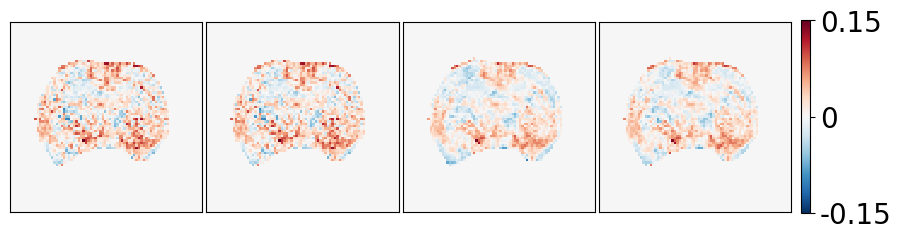

In [62]:
#### zoom plots
########################## FA #####################################
plt.rcParams.update({'font.size': 20})
fig2, ax = plt.subplots(1, 4, figsize=(12, 2.5),
                        subplot_kw={'xticks': [], 'yticks': []})
fig2.subplots_adjust(hspace=0.01, wspace=0.02)

MD =  FA2[:, -1:0:-1, sli] - FA_gs[:, -1:0:-1, sli]

immd = ax.flat[0].imshow(MD.T, cmap='RdBu_r', interpolation='none',
                         vmin=-0.15, vmax=0.15, origin='lower')

MD =  FA_mp2_slow[:, -1:0:-1, sli] - FA_gs[:, -1:0:-1, sli]
immd = ax.flat[1].imshow(MD.T, cmap='RdBu_r', interpolation='none',
                         vmin=-0.15, vmax=0.15, origin='lower')

MD =  FA_ht2[:, -1:0:-1, sli] - FA_gs[:, -1:0:-1, sli]
immd = ax.flat[3].imshow(MD.T, cmap='RdBu_r', interpolation='none',
                         vmin=-0.15, vmax=0.15, origin='lower')

MD =  FA_hv2[:, -1:0:-1, sli] - FA_gs[:, -1:0:-1, sli]
immd = ax.flat[2].imshow(MD.T, cmap='RdBu_r', interpolation='none',
                         vmin=-0.15, vmax=0.15, origin='lower')

cbar = fig2.colorbar(immd, ax=ax.flat[:], ticks=[-0.15, 0.0, 0.15], pad=0.01)
cbar.ax.set_yticklabels(['-0.15', '0', '0.15'])

[Text(1, 0.0, '0'), Text(1, 0.3, '0.3'), Text(1, 0.6, '0.6')]

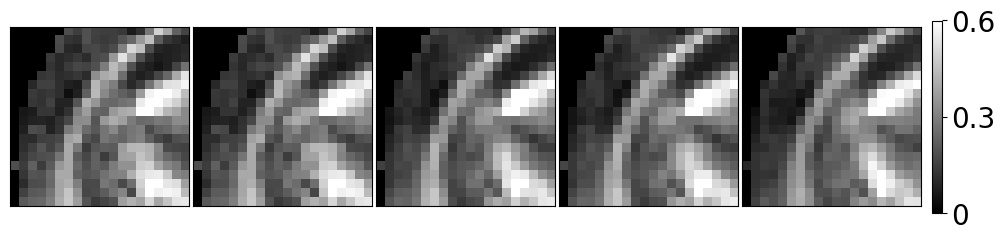

In [63]:
#### zoom plots
########################## FA #####################################

fig2, ax = plt.subplots(1, 5, figsize=(14, 2.5),
                        subplot_kw={'xticks': [], 'yticks': []})
fig2.subplots_adjust(hspace=0.01, wspace=0.02)

MD =  FA2[:, -1:0:-1, sli]
xiii = 10
xfff = 30
yiii = 34
yfff = 54
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[0].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=0.6, origin='lower')

MD =  FA_mp2_slow[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[1].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=0.6, origin='lower')

MD =  FA_ht2[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[3].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=0.6, origin='lower')

MD =  FA_hv2[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[2].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=0.6, origin='lower')

MD =  FA_gs[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[4].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=0.6, origin='lower')
cbar = fig2.colorbar(immd, ax=ax.flat[:], ticks=[0, 0.3, 0.6], pad=0.01)
cbar.ax.set_yticklabels(['0', '0.3', '0.6'])


[Text(1, -0.15, '-0.15'), Text(1, 0.0, '0'), Text(1, 0.15, '0.15')]

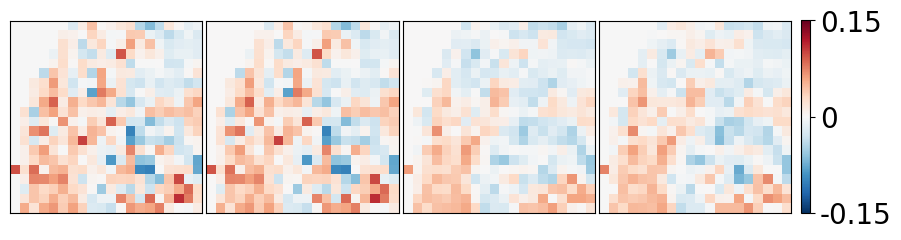

In [64]:
#### zoom plots
########################## FA #####################################
plt.rcParams.update({'font.size': 20})
fig2, ax = plt.subplots(1, 4, figsize=(12, 2.5),
                        subplot_kw={'xticks': [], 'yticks': []})
fig2.subplots_adjust(hspace=0.01, wspace=0.02)

MD =  FA2[:, -1:0:-1, sli] - FA_gs[:, -1:0:-1, sli]
xiii = 10
xfff = 30
yiii = 34
yfff = 54
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[0].imshow(MD.T, cmap='RdBu_r', interpolation='none',
                         vmin=-0.15, vmax=0.15, origin='lower')

MD =  FA_mp2_slow[:, -1:0:-1, sli] - FA_gs[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[1].imshow(MD.T, cmap='RdBu_r', interpolation='none',
                         vmin=-0.15, vmax=0.15, origin='lower')

MD =  FA_ht2[:, -1:0:-1, sli] - FA_gs[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[3].imshow(MD.T, cmap='RdBu_r', interpolation='none',
                         vmin=-0.15, vmax=0.15, origin='lower')

MD =  FA_hv2[:, -1:0:-1, sli] - FA_gs[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[2].imshow(MD.T, cmap='RdBu_r', interpolation='none',
                         vmin=-0.15, vmax=0.15, origin='lower')

cbar = fig2.colorbar(immd, ax=ax.flat[:], ticks=[-0.15, 0.0, 0.15], pad=0.01)
cbar.ax.set_yticklabels(['-0.15', '0', '0.15'])

[Text(1, -0.3, '-0.3'), Text(1, 0.0, '0'), Text(1, 0.3, '0.3')]

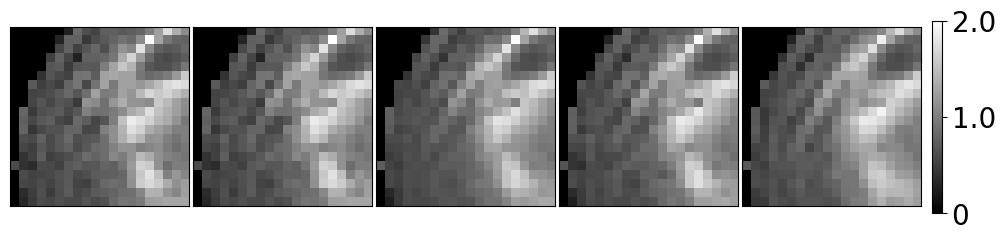

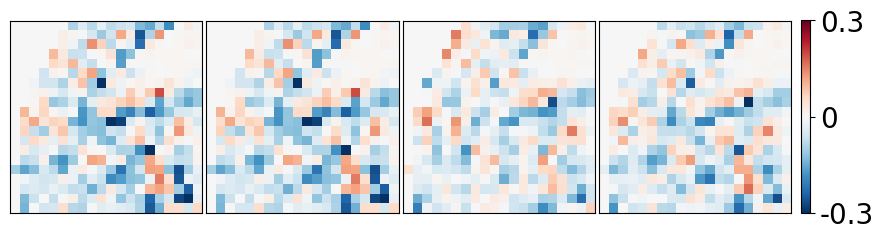

In [65]:
#### zoom plots
########################## FA #####################################

fig2, ax = plt.subplots(1, 5, figsize=(14, 2.5),
                        subplot_kw={'xticks': [], 'yticks': []})
fig2.subplots_adjust(hspace=0.01, wspace=0.02)

MD =  MK2[:, -1:0:-1, sli]
xiii = 10
xfff = 30
yiii = 34
yfff = 54
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[0].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=2, origin='lower')

MD =  MK_mp2_slow[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[1].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=2, origin='lower')

MD =  MK_ht2[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[3].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=2, origin='lower')

MD =  MK_hv2[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[2].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=2, origin='lower')

MD =  MK_gs[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[4].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=2, origin='lower')
cbar = fig2.colorbar(immd, ax=ax.flat[:], ticks=[0, 1, 2], pad=0.01)
cbar.ax.set_yticklabels(['0', '1.0', '2.0'])

#### zoom plots
########################## FA #####################################

fig2, ax = plt.subplots(1, 4, figsize=(12, 2.5),
                        subplot_kw={'xticks': [], 'yticks': []})
fig2.subplots_adjust(hspace=0.01, wspace=0.02)

MD =  MK2[:, -1:0:-1, sli] - MK_gs[:, -1:0:-1, sli]
xiii = 10
xfff = 30
yiii = 34
yfff = 54
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[0].imshow(MD.T, cmap='RdBu_r', interpolation='none',
                         vmin=-0.3, vmax=0.3, origin='lower')

MD =  MK_mp2_slow[:, -1:0:-1, sli] - MK_gs[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[1].imshow(MD.T, cmap='RdBu_r', interpolation='none',
                         vmin=-0.3, vmax=0.3, origin='lower')

MD =  MK_ht2[:, -1:0:-1, sli] - MK_gs[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[3].imshow(MD.T, cmap='RdBu_r', interpolation='none',
                         vmin=-0.3, vmax=0.3, origin='lower')

MD =  MK_hv2[:, -1:0:-1, sli] - MK_gs[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[2].imshow(MD.T, cmap='RdBu_r', interpolation='none',
                         vmin=-0.3, vmax=0.3, origin='lower')


cbar = fig2.colorbar(immd, ax=ax.flat[:], ticks=[-0.3, 0, 0.3], pad=0.01)
cbar.ax.set_yticklabels(['-0.3', '0', '0.3'])

[Text(1, -0.4, '-0.4'), Text(1, 0.0, '0'), Text(1, 0.4, '0.4')]

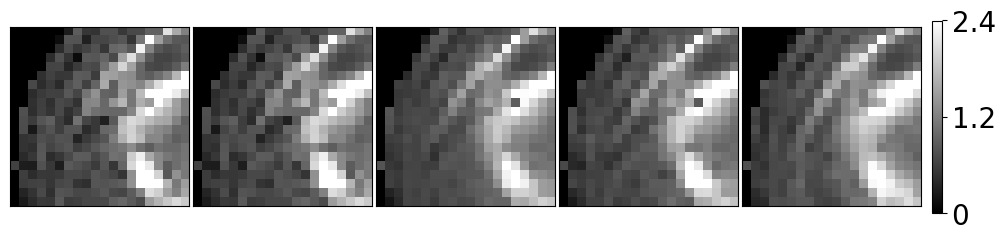

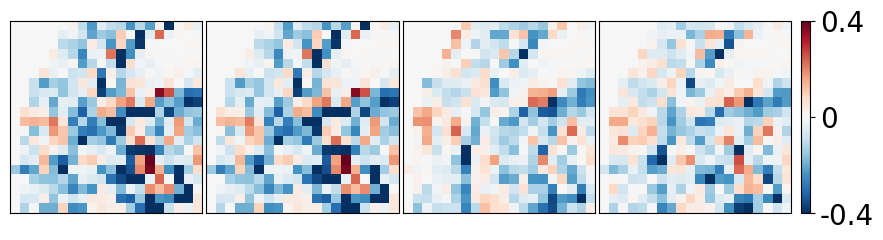

In [66]:
#### zoom plots
########################## FA #####################################

fig2, ax = plt.subplots(1, 5, figsize=(14, 2.5),
                        subplot_kw={'xticks': [], 'yticks': []})
fig2.subplots_adjust(hspace=0.01, wspace=0.02)

MD =  RK2[:, -1:0:-1, sli]
xiii = 10
xfff = 30
yiii = 34
yfff = 54
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[0].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=2.4, origin='lower')

MD =  RK_mp2_slow[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[1].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=2.4, origin='lower')

MD =  RK_ht2[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[3].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=2.4, origin='lower')

MD =  RK_hv2[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[2].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=2.4, origin='lower')

MD =  RK_gs[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[4].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=2.4, origin='lower')
cbar = fig2.colorbar(immd, ax=ax.flat[:], ticks=[0, 1.2, 2.4], pad=0.01)
cbar.ax.set_yticklabels(['0', '1.2', '2.4'])

#### zoom plots
########################## FA #####################################

fig2, ax = plt.subplots(1, 4, figsize=(12, 2.5),
                        subplot_kw={'xticks': [], 'yticks': []})
fig2.subplots_adjust(hspace=0.01, wspace=0.02)

MD =  RK2[:, -1:0:-1, sli] - RK_gs[:, -1:0:-1, sli]
xiii = 10
xfff = 30
yiii = 34
yfff = 54
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[0].imshow(MD.T, cmap='RdBu_r', interpolation='none',
                         vmin=-0.4, vmax=0.4, origin='lower')

MD =  RK_mp2_slow[:, -1:0:-1, sli] - RK_gs[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[1].imshow(MD.T, cmap='RdBu_r', interpolation='none',
                         vmin=-0.4, vmax=0.4, origin='lower')

MD =  RK_ht2[:, -1:0:-1, sli] - RK_gs[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[3].imshow(MD.T, cmap='RdBu_r', interpolation='none',
                         vmin=-0.4, vmax=0.4, origin='lower')

MD =  RK_hv2[:, -1:0:-1, sli] - RK_gs[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[2].imshow(MD.T, cmap='RdBu_r', interpolation='none',
                         vmin=-0.4, vmax=0.4, origin='lower')


cbar = fig2.colorbar(immd, ax=ax.flat[:], ticks=[-0.4, 0, 0.4], pad=0.01)
cbar.ax.set_yticklabels(['-0.4', '0', '0.4'])

[Text(1, -0.4, '-0.4'), Text(1, 0.0, '0'), Text(1, 0.4, '0.4')]

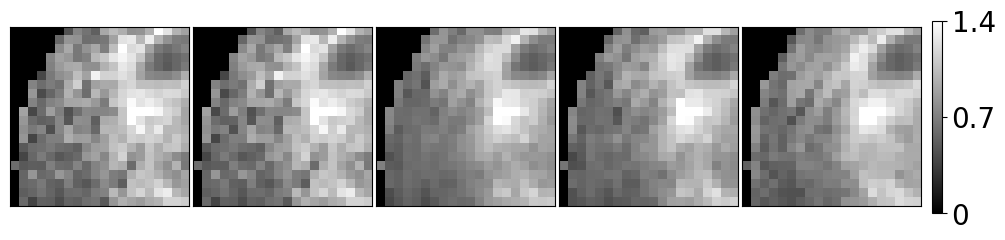

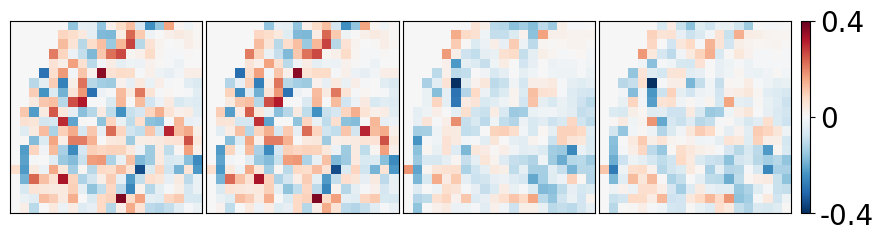

In [67]:
#### zoom plots
########################## FA #####################################

fig2, ax = plt.subplots(1, 5, figsize=(14, 2.5),
                        subplot_kw={'xticks': [], 'yticks': []})
fig2.subplots_adjust(hspace=0.01, wspace=0.02)

MD =  AK2[:, -1:0:-1, sli]
xiii = 10
xfff = 30
yiii = 34
yfff = 54
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[0].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=1.4, origin='lower')

MD =  AK_mp2_slow[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[1].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=1.4, origin='lower')

MD =  AK_ht2[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[3].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=1.4, origin='lower')

MD =  AK_hv2[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[2].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=1.4, origin='lower')

MD =  AK_gs[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[4].imshow(MD.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=1.4, origin='lower')
cbar = fig2.colorbar(immd, ax=ax.flat[:], ticks=[0, 0.7, 1.4], pad=0.01)
cbar.ax.set_yticklabels(['0', '0.7', '1.4'])

#### zoom plots
########################## FA #####################################

fig2, ax = plt.subplots(1, 4, figsize=(12, 2.5),
                        subplot_kw={'xticks': [], 'yticks': []})
fig2.subplots_adjust(hspace=0.01, wspace=0.02)

MD =  AK2[:, -1:0:-1, sli] - AK_gs[:, -1:0:-1, sli]
xiii = 10
xfff = 30
yiii = 34
yfff = 54
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[0].imshow(MD.T, cmap='RdBu_r', interpolation='none',
                         vmin=-0.4, vmax=0.4, origin='lower')

MD =  AK_mp2_slow[:, -1:0:-1, sli] - AK_gs[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[1].imshow(MD.T, cmap='RdBu_r', interpolation='none',
                         vmin=-0.4, vmax=0.4, origin='lower')

MD =  AK_ht2[:, -1:0:-1, sli] - AK_gs[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[3].imshow(MD.T, cmap='RdBu_r', interpolation='none',
                         vmin=-0.4, vmax=0.4, origin='lower')

MD =  AK_hv2[:, -1:0:-1, sli] - AK_gs[:, -1:0:-1, sli]
MD = MD[xiii:xfff, yiii:yfff]
immd = ax.flat[2].imshow(MD.T, cmap='RdBu_r', interpolation='none',
                         vmin=-0.4, vmax=0.4, origin='lower')


cbar = fig2.colorbar(immd, ax=ax.flat[:], ticks=[-0.4, 0, 0.4], pad=0.01)
cbar.ax.set_yticklabels(['-0.4', '0', '0.4'])

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109


Text(0.5, 0, 'r')

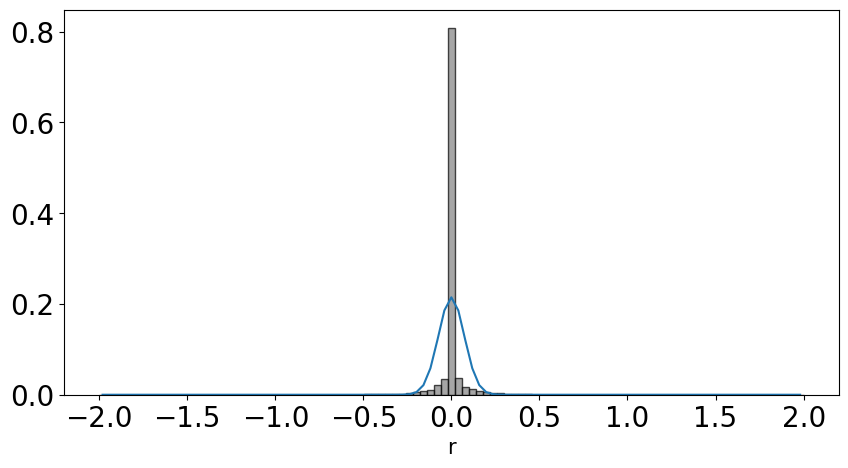

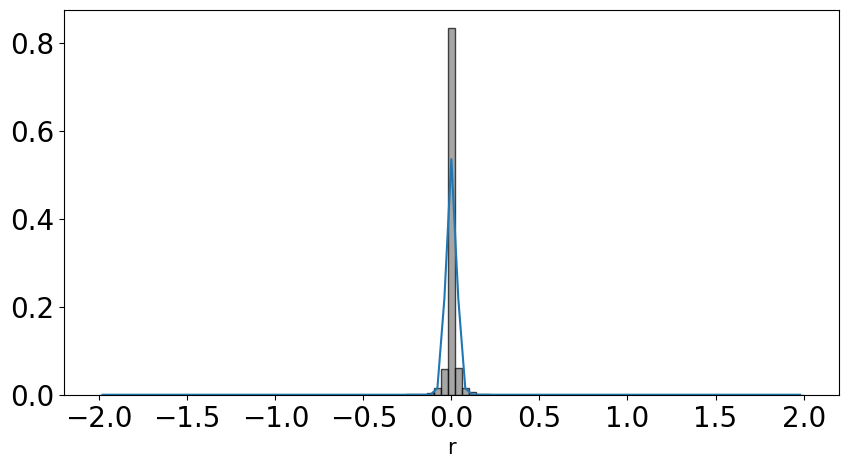

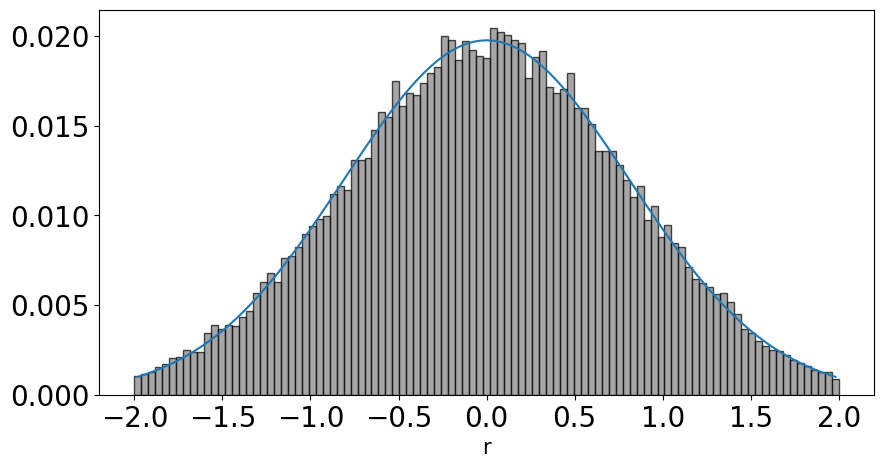

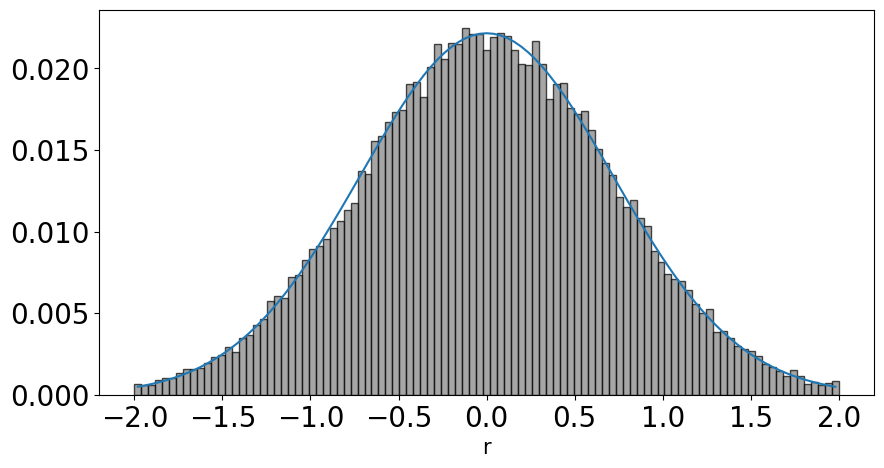

In [68]:
# select portion of the data (important because STD is spatially variant)
roi = np.zeros((80, 79))
# region shown in Figure 4
xiii = 10
xfff = 30
yiii = 34
yfff = 54
roi[xiii:xfff, yiii:yfff] = 1

Rmp1_all = den_mp2 - data2
Rmp1_slow_all = den_mp2_slow - data2
Rht1_all = den_ht2 - data2
Rhv1_all = den_hv2 - data2

Rmp1 = Rmp1_all[:, -1:0:-1, sli, vols_sel[0]]
Rmp1_slow = Rmp1_slow_all[:, -1:0:-1, sli, vols_sel[0]]
Rht1 = Rht1_all[:, -1:0:-1, sli, vols_sel[0]]
Rhv1 = Rhv1_all[:, -1:0:-1, sli, vols_sel[0]]

Rmp1_vec = Rmp1[roi==1]
Rmp1_slow_vec = Rmp1_slow[roi==1]
Rht1_vec = Rht1[roi==1]
Rhv1_vec = Rhv1[roi==1]

for vi in range(1, vols_sel.size):
    Rmp1 = Rmp1_all[:, -1:0:-1, sli, vols_sel[vi]]
    Rmp1_slow = Rmp1_slow_all[:, -1:0:-1, sli, vols_sel[vi]]
    Rht1 = Rht1_all[:, -1:0:-1, sli, vols_sel[vi]]
    Rhv1 = Rhv1_all[:, -1:0:-1, sli, vols_sel[vi]]
    Rmp1_vec = np.append(Rmp1_vec, Rmp1[roi==1])
    Rmp1_slow_vec = np.append(Rmp1_slow_vec, Rmp1_slow[roi==1])
    Rht1_vec = np.append(Rht1_vec, Rht1[roi==1])
    Rhv1_vec = np.append(Rhv1_vec, Rhv1[roi==1])
    print(vi)

sffmp1 = np.std(Rmp1_vec)
sffmp1_slow = np.std(Rmp1_slow_vec)
sffht1 = np.std(Rht1_vec)
sffhv1 = np.std(Rhv1_vec)

rpos = 2
rneg = -2
nb = 101

x = np.linspace(rneg, rpos, num=nb)

# Reference 
prefmp1 = np.exp(-1/2 * (x/sffmp1)**2)
prefmp1 = prefmp1 / np.sum(prefmp1)

prefmp1_slow = np.exp(-1/2 * (x/sffmp1_slow)**2)
prefmp1_slow = prefmp1_slow / np.sum(prefmp1_slow)

prefht1 = np.exp(-1/2 * (x/sffht1)**2)
prefht1 = prefht1 / np.sum(prefht1)

prefhv1 = np.exp(-1/2 * (x/sffhv1)**2)
prefhv1 = prefhv1 / np.sum(prefhv1)

# Bins
beig, ed = np.histogram(Rmp1_vec, bins = nb, range=(rneg, rpos))
beig_mp1 = beig / np.sum(beig)

beig, ed = np.histogram(Rmp1_slow_vec, bins = nb, range=(rneg, rpos))
beig_mp1_slow = beig / np.sum(beig)

beig, ed = np.histogram(Rhv1_vec, bins = nb, range=(rneg, rpos))
beig_hv1 = beig / np.sum(beig)

beig, ed = np.histogram(Rht1_vec, bins = nb, range=(rneg, rpos))
beig_ht1 = beig / np.sum(beig)

fig = plt.figure(figsize=(10, 5))
plt.bar(ed[:-1]+(rpos-rneg)/(2*nb), beig_mp1, width = (rpos-rneg)/nb, color='grey', alpha=0.7, edgecolor='black', label='measured dist.')
plt.plot(ed[:-1]+(rpos-rneg)/(2*nb), prefmp1)
plt.xlabel('r', fontsize=15)

fig = plt.figure(figsize=(10, 5))
plt.bar(ed[:-1]+(rpos-rneg)/(2*nb), beig_mp1_slow, width = (rpos-rneg)/nb, color='grey', alpha=0.7, edgecolor='black', label='measured dist.')
plt.plot(ed[:-1]+(rpos-rneg)/(2*nb), prefmp1_slow)
plt.xlabel('r', fontsize=15)

fig = plt.figure(figsize=(10, 5))
plt.bar(ed[:-1]+(rpos-rneg)/(2*nb), beig_hv1, width = (rpos-rneg)/nb, color='grey', alpha=0.7, edgecolor='black', label='measured dist.')
plt.plot(ed[:-1]+(rpos-rneg)/(2*nb), prefhv1)
plt.xlabel('r', fontsize=15)

fig = plt.figure(figsize=(10, 5))
plt.bar(ed[:-1]+(rpos-rneg)/(2*nb), beig_ht1, width = (rpos-rneg)/nb, color='grey', alpha=0.7, edgecolor='black', label='measured dist.')
plt.plot(ed[:-1]+(rpos-rneg)/(2*nb), prefht1)
plt.xlabel('r', fontsize=15)

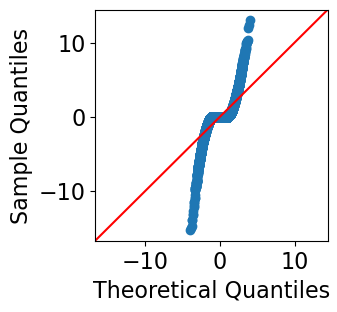

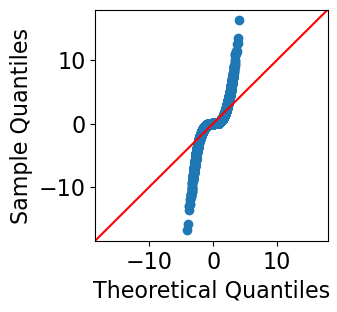

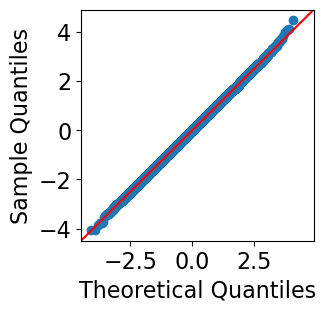

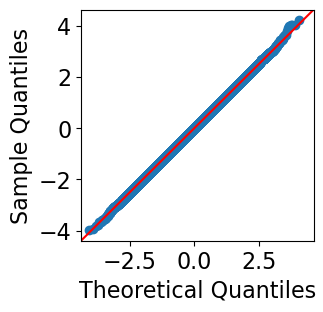

In [69]:
import matplotlib as mpl
plt.rcParams.update({'font.size': 16})
with mpl.rc_context():
    mpl.rc("figure", figsize=(3, 3))
    sm.qqplot(Rmp1_vec, line='45', fit=True)
    pylab.show()
    sm.qqplot(Rmp1_slow_vec, line='45', fit=True)
    pylab.show()
    sm.qqplot(Rhv1_vec, line='45', fit=True)
    pylab.show()
    sm.qqplot(Rht1_vec, line='45', fit=True)
    pylab.show()